# Zero inflated bionomial

## function: zeroinflatedbinomial (L-BFGS-B)

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.stats import binom, norm
from scipy.special import expit, logit
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
import time

class ZeroInflatedBinomial:
    """Zero-Inflated Binomial"""
    
    def __init__(self, n_trials=9):
        self.n_trials = n_trials
        self.fitted = False
        self.params = None
        self.se = None
        self.scaler = StandardScaler()
        
    def _loglik(self, params, y, X):
        """Ë¥üÂØπÊï∞‰ººÁÑ∂ÂáΩÊï∞"""
        n_obs, n_features = X.shape
        
        # ÂèÇÊï∞ÂàÜËß£
        alpha_zi = params[0]
        beta_zi = params[1:n_features+1]
        alpha_bin = params[n_features+1]
        beta_bin = params[n_features+2:]
        
        # Á∫øÊÄßÈ¢ÑÊµãÂô®
        logit_psi = alpha_zi + X @ beta_zi
        logit_p = alpha_bin + X @ beta_bin
        
        # ËΩ¨Êç¢‰∏∫Ê¶ÇÁéáÔºåÈÅøÂÖçÊï∞ÂÄºÈóÆÈ¢ò
        psi = expit(np.clip(logit_psi, -20, 20))  # zero-inflationÊ¶ÇÁéá
        p = expit(np.clip(logit_p, -20, 20))      # binomialÊàêÂäüÊ¶ÇÁéá
        
        # Zero-inflated binomial likelihood
        ll = np.zeros(n_obs)
        
        # y=0ÁöÑÊÉÖÂÜµ
        zero_mask = (y == 0)
        if np.any(zero_mask):
            prob_zero_zi = psi[zero_mask]  # Êù•Ëá™zero-inflation
            prob_zero_bin = (1 - psi[zero_mask]) * binom.pmf(0, self.n_trials, p[zero_mask])  # Êù•Ëá™binomial
            ll[zero_mask] = np.log(np.maximum(prob_zero_zi + prob_zero_bin, 1e-15))
        
        # y>0ÁöÑÊÉÖÂÜµ  
        nonzero_mask = ~zero_mask
        if np.any(nonzero_mask):
            prob_nonzero = (1 - psi[nonzero_mask]) * binom.pmf(y[nonzero_mask], self.n_trials, p[nonzero_mask])
            ll[nonzero_mask] = np.log(np.maximum(prob_nonzero, 1e-15))
        
        return -np.sum(ll)  # ËøîÂõûË¥üÂØπÊï∞‰ººÁÑ∂
    
    def _gradient(self, params, y, X):
        """Ê¢ØÂ∫¶ÂáΩÊï∞ÔºàÊï∞ÂÄºÊ¢ØÂ∫¶Ôºâ"""
        eps = 1e-6
        grad = np.zeros_like(params)
        f0 = self._loglik(params, y, X)
        
        for i in range(len(params)):
            params_plus = params.copy()
            params_plus[i] += eps
            grad[i] = (self._loglik(params_plus, y, X) - f0) / eps
            
        return grad
    
    def fit(self, X, y, standardize=True, method='L-BFGS-B', maxiter=1000):
        """ÊãüÂêàÊ®°Âûã"""
        # Êï∞ÊçÆÈ¢ÑÂ§ÑÁêÜ
        X = np.asarray(X)
        y = np.asarray(y)
        
        if X.ndim == 1:
            X = X.reshape(-1, 1)
            
        if standardize:
            X = self.scaler.fit_transform(X)
        
        n_obs, n_features = X.shape
        
        # ÂàùÂßãÂèÇÊï∞‰º∞ËÆ°
        # ‰ΩøÁî®ÁÆÄÂçïÁöÑÂêØÂèëÂºèÊñπÊ≥ï
        zero_prop = np.mean(y == 0)
        mean_nonzero = np.mean(y[y > 0]) if np.any(y > 0) else 0.5
        
        # ÂàùÂßãÂÄº
        initial_psi = np.clip(zero_prop * 1.2, 0.01, 0.99)  # zero-inflationÊ¶ÇÁéá
        initial_p = np.clip(mean_nonzero / self.n_trials, 0.01, 0.99)  # binomialÊ¶ÇÁéá
        
        initial_params = np.concatenate([
            [logit(initial_psi)],  # alpha_zi
            np.zeros(n_features),  # beta_zi
            [logit(initial_p)],    # alpha_bin  
            np.zeros(n_features)   # beta_bin
        ])
        
        print(f"ÂºÄÂßãÊãüÂêàÊ®°Âûã... Ê†∑Êú¨Êï∞: {n_obs}, ÁâπÂæÅÊï∞: {n_features}")
        print(f"Èõ∂ÂÄºÊØî‰æã: {zero_prop:.3f}")
        print(f"ÂàùÂßãzero-inflationÊ¶ÇÁéá: {initial_psi:.3f}")
        print(f"ÂàùÂßãbinomialÊ¶ÇÁéá: {initial_p:.3f}")

        progress = tqdm(total=maxiter, desc="‰ºòÂåñËøõÂ∫¶", position=0)
        def callback(xk):
            # ÊØèÊ¨°Ëø≠‰ª£Ë∞ÉÁî®‰∏ÄÊ¨°
            progress.update(1)
        
        # ‰ºòÂåñ
        try:
            result = minimize(
                fun=self._loglik,
                x0=initial_params,
                args=(y, X),
                method=method,
                jac=self._gradient,
                options={'maxiter': maxiter, 'disp': True},
                callback=callback
            )
            progress.close()
            
            if not result.success:
                print(f"Warning: ‰ºòÂåñÂèØËÉΩÊú™Êî∂Êïõ. Message: {result.message}")
            
            self.params = result.x
            self.result = result
            
            # ËÆ°ÁÆóÊ†áÂáÜËØØÔºà‰ΩøÁî®HessianÁü©ÈòµÔºâ
            try:
                hessian = self._compute_hessian(X, y)
                self.se = np.sqrt(np.diag(np.linalg.inv(hessian)))
            except:
                print("Warning: Êó†Ê≥ïËÆ°ÁÆóÊ†áÂáÜËØØ")
                self.se = None
            
            self.fitted = True
            
            print(f"‰ºòÂåñÂÆåÊàê. Ë¥üÂØπÊï∞‰ººÁÑ∂: {result.fun:.4f}")
            print("scaler mean, scale:", self.scaler.mean_, self.scaler.scale_)
            return self
            
        except Exception as e:
            print(f"ÊãüÂêàÂ§±Ë¥•: {e}")
            raise
        
    def _compute_hessian(self, X, y):
        """Êï∞ÂÄºËÆ°ÁÆóHessianÁü©Èòµ"""
        eps = 1e-6
        n_params = len(self.params)
        hessian = np.zeros((n_params, n_params))
        
        f0 = self._loglik(self.params, y, X)
        
        for i in range(n_params):
            for j in range(i, n_params):
                # ËÆ°ÁÆó‰∫åÈò∂ÂÅèÂØºÊï∞
                params_ij = self.params.copy()
                params_ij[i] += eps
                params_ij[j] += eps
                f_ij = self._loglik(params_ij, y, X)
                
                params_i = self.params.copy()
                params_i[i] += eps
                f_i = self._loglik(params_i, y, X)
                
                params_j = self.params.copy()
                params_j[j] += eps
                f_j = self._loglik(params_j, y, X)
                
                hessian[i, j] = (f_ij - f_i - f_j + f0) / (eps * eps)
                hessian[j, i] = hessian[i, j]
        
        return hessian
    
    def predict_proba(self, X):
        """È¢ÑÊµãÊ¶ÇÁéá"""
        if not self.fitted:
            raise ValueError("Ê®°ÂûãÊú™ÊãüÂêà")
        
        X = np.asarray(X)
        if X.ndim == 1:
            X = X.reshape(-1, 1)
        
        X = self.scaler.transform(X)
        n_features = X.shape[1]
        
        # ÊèêÂèñÂèÇÊï∞
        alpha_zi = self.params[0]
        beta_zi = self.params[1:n_features+1]
        alpha_bin = self.params[n_features+1]
        beta_bin = self.params[n_features+2:]
        
        # ËÆ°ÁÆóÊ¶ÇÁéá
        logit_psi = alpha_zi + X @ beta_zi
        logit_p = alpha_bin + X @ beta_bin
        
        psi = expit(logit_psi)  # zero-inflationÊ¶ÇÁéá
        p = expit(logit_p)      # binomialÊàêÂäüÊ¶ÇÁéá
        
        # ËÆ°ÁÆóÊØè‰∏™ÂèØËÉΩÂÄºÁöÑÊ¶ÇÁéá
        probs = np.zeros((len(X), self.n_trials + 1))
        
        for k in range(self.n_trials + 1):
            if k == 0:
                # P(Y=0) = psi + (1-psi) * P(Bin=0)
                probs[:, k] = psi + (1 - psi) * binom.pmf(0, self.n_trials, p)
            else:
                # P(Y=k) = (1-psi) * P(Bin=k)
                probs[:, k] = (1 - psi) * binom.pmf(k, self.n_trials, p)
        
        return probs, psi, p
    
    def predict(self, X):
        """È¢ÑÊµãÊúüÊúõÂÄº"""
        probs, psi, p = self.predict_proba(X)
        # ÊúüÊúõÂÄº = (1-psi) * n * p
        return (1 - psi) * self.n_trials * p
    
    def summary(self):
        """Ê®°ÂûãÊëòË¶Å"""
        if not self.fitted:
            raise ValueError("Ê®°ÂûãÊú™ÊãüÂêà")
        
        n_features = (len(self.params) - 2) // 2
        
        print("Zero-Inflated BinomialÂõûÂΩíÁªìÊûú")
        print("=" * 50)
        print(f"ËßÇÊµãÊï∞: {len(self.params)//2}")  # Ëøë‰ºº
        print(f"Ë¥üÂØπÊï∞‰ººÁÑ∂: {self.result.fun:.4f}")
        print(f"AIC: {2 * len(self.params) + 2 * self.result.fun:.4f}")
        print()
        
        # Zero-inflationÈÉ®ÂàÜ
        print("Zero-inflationÈÉ®ÂàÜ (logit):")
        print("-" * 30)
        print(f"{'ÂèÇÊï∞':<15} {'‰º∞ËÆ°ÂÄº':<10} {'Ê†áÂáÜËØØ':<10} {'ZÂÄº':<10} {'PÂÄº':<10}")
        
        alpha_zi = self.params[0]
        if self.se is not None:
            se_alpha_zi = self.se[0]
            z_alpha_zi = alpha_zi / se_alpha_zi
            p_alpha_zi = 2 * (1 - norm.cdf(abs(z_alpha_zi)))
            print(f"{'Intercept':<15} {alpha_zi:<10.4f} {se_alpha_zi:<10.4f} {z_alpha_zi:<10.4f} {p_alpha_zi:<10.4f}")
        else:
            print(f"{'Intercept':<15} {alpha_zi:<10.4f} {'N/A':<10} {'N/A':<10} {'N/A':<10}")
        
        for i in range(n_features):
            beta_zi = self.params[1 + i]
            param_name = f"X{i+1}" if n_features > 1 else "X"
            if self.se is not None:
                se_beta_zi = self.se[1 + i]
                z_beta_zi = beta_zi / se_beta_zi
                p_beta_zi = 2 * (1 - norm.cdf(abs(z_beta_zi)))
                print(f"{param_name:<15} {beta_zi:<10.4f} {se_beta_zi:<10.4f} {z_beta_zi:<10.4f} {p_beta_zi:<10.4f}")
            else:
                print(f"{param_name:<15} {beta_zi:<10.4f} {'N/A':<10} {'N/A':<10} {'N/A':<10}")
        
        print()
        # BinomialÈÉ®ÂàÜ
        print("BinomialÈÉ®ÂàÜ (logit):")
        print("-" * 30)
        print(f"{'ÂèÇÊï∞':<15} {'‰º∞ËÆ°ÂÄº':<10} {'Ê†áÂáÜËØØ':<10} {'ZÂÄº':<10} {'PÂÄº':<10}")
        
        alpha_bin = self.params[n_features + 1]
        if self.se is not None:
            se_alpha_bin = self.se[n_features + 1]
            z_alpha_bin = alpha_bin / se_alpha_bin
            p_alpha_bin = 2 * (1 - norm.cdf(abs(z_alpha_bin)))
            print(f"{'Intercept':<15} {alpha_bin:<10.4f} {se_alpha_bin:<10.4f} {z_alpha_bin:<10.4f} {p_alpha_bin:<10.4f}")
        else:
            print(f"{'Intercept':<15} {alpha_bin:<10.4f} {'N/A':<10} {'N/A':<10} {'N/A':<10}")
        
        for i in range(n_features):
            beta_bin = self.params[n_features + 2 + i]
            param_name = f"X{i+1}" if n_features > 1 else "X"
            if self.se is not None:
                se_beta_bin = self.se[n_features + 2 + i]
                z_beta_bin = beta_bin / se_beta_bin
                p_beta_bin = 2 * (1 - norm.cdf(abs(z_beta_bin)))
                print(f"{param_name:<15} {beta_bin:<10.4f} {se_beta_bin:<10.4f} {z_beta_bin:<10.4f} {p_beta_bin:<10.4f}")
            else:
                print(f"{param_name:<15} {beta_bin:<10.4f} {'N/A':<10} {'N/A':<10} {'N/A':<10}")
    
    def plot_fit(self, X, y, feature_name="Remoteness", sample_size=5000):
        """Plot ZIB model results with non-structural-zero expectation in English"""
        if not self.fitted:
            raise ValueError("Model is not fitted yet")
        
        X = np.asarray(X).flatten()
        y = np.asarray(y)
        
        # ÊäΩÊ†∑ÁªòÂõæÔºåÊèêÂçáÈÄüÂ∫¶
        if len(X) > sample_size:
            idx = np.random.choice(len(X), size=sample_size, replace=False)
            X_plot = X[idx]
            y_plot = y[idx]
        else:
            X_plot = X
            y_plot = y
        
        # ÂàõÂª∫È¢ÑÊµãÁΩëÊ†º
        x_range = np.linspace(X.min(), X.max(), 100)
        probs, psi, p = self.predict_proba(x_range.reshape(-1, 1))
        # ËìùÁ∫øÊîπ‰∏∫ÈùûÁªìÊûÑÊÄßÈõ∂Ê†ºÂ≠êÊúüÊúõÂª∫Á≠ëÊï∞
        pred_mean_nonstructural = self.n_trials * p
        
        fig, axes = plt.subplots(2, 2, figsize=(12, 10))
        
        # ËßÇÊµãÊï∞ÊçÆÂàÜÂ∏É
        axes[0, 0].hist(y_plot, bins=range(self.n_trials + 2), alpha=0.7, density=True, edgecolor='black')
        axes[0, 0].set_title('Observed Building Count Distribution')
        axes[0, 0].set_xlabel('Number of Buildings per Cell')
        axes[0, 0].set_ylabel('Density')
        
        # Zero-inflation probability
        axes[0, 1].scatter(X_plot, y_plot == 0, alpha=0.3, s=1)
        axes[0, 1].plot(x_range, psi, 'r-', linewidth=2, label='Predicted Zero-Inflation Probability')
        axes[0, 1].set_title('Zero-Inflation Probability')
        axes[0, 1].set_xlabel(feature_name)
        axes[0, 1].set_ylabel('P(Y=0 | structural zero)')
        axes[0, 1].legend()
        
        # Binomial success probability
        nonzero_mask = y_plot > 0
        if np.any(nonzero_mask):
            axes[1, 0].scatter(X_plot[nonzero_mask], y_plot[nonzero_mask]/self.n_trials, alpha=0.3, s=1)
        axes[1, 0].plot(x_range, p, 'g-', linewidth=2, label='Predicted Binomial Success Probability')
        axes[1, 0].set_title('Binomial Success Probability (Non-Structural Zero Cells)')
        axes[1, 0].set_xlabel(feature_name)
        axes[1, 0].set_ylabel('Success Probability per Trial')
        axes[1, 0].legend()
        
        # Non-structural zero expected building count
        axes[1, 1].scatter(X_plot, y_plot, alpha=0.3, s=1)
        axes[1, 1].plot(x_range, pred_mean_nonstructural, 'b-', linewidth=2, label='Expected Building Count (Non-Structural Zero Cells)')
        axes[1, 1].set_title('Expected Building Count per Non-Structural Zero Cell')
        axes[1, 1].set_xlabel(feature_name)
        axes[1, 1].set_ylabel('Expected Buildings')
        axes[1, 1].legend()
        
        plt.tight_layout()
        plt.show()

## Read csv of 3 case cities

In [7]:
# Antananarivo
df_16 = pd.read_csv("aggregated_data/Antananarivo_2016_3x3_windows.csv")
cities = pd.read_csv("CitiesDB_new.csv")
pop_16 = cities.loc[cities['Name'] == 'Antananarivo', 'pop_2016_UN'].iloc[0] * 1000
df_16['remoteness'] = (df_16['distance_to_center'] / np.sqrt(pop_16)) * 1000
df_16['bd'] = 9

In [8]:
# Antananarivo Sample 10k
df_16_sample = pd.read_csv("df_sample_16_Anta_10k.csv")
cities = pd.read_csv("CitiesDB_new.csv")
pop_16 = cities.loc[cities['Name'] == 'Antananarivo', 'pop_2016_UN'].iloc[0] * 1000
df_16_sample['remoteness'] = (df_16_sample['distance_to_center'] / np.sqrt(pop_16)) * 1000
df_16_sample['bd'] = 9

In [9]:
# Mumbai
df_16_mumbai = pd.read_csv("aggregated_data/Mumbai_2016_3x3_windows.csv")
cities = pd.read_csv("CitiesDB_new.csv")
pop_16 = cities.loc[cities['Name'] == 'Mumbai', 'pop_2016_UN'].iloc[0] * 1000
df_16_mumbai['remoteness'] = (df_16_mumbai['distance_to_center'] / np.sqrt(pop_16)) * 1000
df_16_mumbai['bd'] = 9

In [10]:
# Mexico City
df_16_mexico = pd.read_csv("aggregated_data/Mexico City_2016_3x3_windows.csv")
cities = pd.read_csv("CitiesDB_new.csv")
pop_16 = cities.loc[cities['Name'] == 'Mexico City', 'pop_2016_UN'].iloc[0] * 1000
df_16_mexico['remoteness'] = (df_16_mexico['distance_to_center'] / np.sqrt(pop_16)) * 1000
df_16_mexico['bd'] = 9

## test ZIB on 3 case cities

### Antananarivo Sample

In [4]:
import time
from tqdm import tqdm

model_sample = ZeroInflatedBinomial(n_trials=9)

start = time.time()
result_all_sample = model_sample.fit(df_16_sample[['remoteness']], df_16_sample['building_count'], maxiter=200)
end = time.time()

print(f"ÊÄªËÄóÊó∂: {end - start:.2f} Áßí")

params_orig = unscale_params(model_sample)
print("Unscaled params (alpha_zi, beta_zi, alpha_bin, beta_bin):", params_orig)

ÂºÄÂßãÊãüÂêàÊ®°Âûã... Ê†∑Êú¨Êï∞: 100000, ÁâπÂæÅÊï∞: 1
Èõ∂ÂÄºÊØî‰æã: 0.927
ÂàùÂßãzero-inflationÊ¶ÇÁéá: 0.990
ÂàùÂßãbinomialÊ¶ÇÁéá: 0.246


‰ºòÂåñËøõÂ∫¶:   6%|‚ñà‚ñâ                              | 12/200 [00:00<00:10, 18.17it/s]


‰ºòÂåñÂÆåÊàê. Ë¥üÂØπÊï∞‰ººÁÑ∂: 32210.8088
scaler mean, scale: [8.95707856] [3.33724346]
ÊÄªËÄóÊó∂: 0.91 Áßí
Unscaled params (alpha_zi, beta_zi, alpha_bin, beta_bin): [-0.42666343  0.38376954 -0.66567337 -0.13555972]


### Antananarivo

In [8]:
import time
from tqdm import tqdm

model = ZeroInflatedBinomial(n_trials=9)

start = time.time()
result_all = model.fit(df_16[['remoteness']], df_16['building_count'], maxiter=200)
end = time.time()

print(f"ÊÄªËÄóÊó∂: {end - start:.2f} Áßí")

ÂºÄÂßãÊãüÂêàÊ®°Âûã... Ê†∑Êú¨Êï∞: 15992001, ÁâπÂæÅÊï∞: 1
Èõ∂ÂÄºÊØî‰æã: 0.928
ÂàùÂßãzero-inflationÊ¶ÇÁéá: 0.990
ÂàùÂßãbinomialÊ¶ÇÁéá: 0.247


‰ºòÂåñËøõÂ∫¶:   6%|‚ñà‚ñâ                              | 12/200 [01:54<29:53,  9.54s/it]


‰ºòÂåñÂÆåÊàê. Ë¥üÂØπÊï∞‰ººÁÑ∂: 5102888.0905
scaler mean, scale: [8.95732042] [3.33862208]
ÊÄªËÄóÊó∂: 157.43 Áßí


In [13]:
# params = result_all.params
# print(params)
# params_sample = result_all_sample.params
# print(params_sample)

In [11]:
mu = 8.95707856
sigma = 3.33724346
alpha_zi_std = params[0]; beta_zi_std = params[1]
alpha_bin_std = params[2]; beta_bin_std = params[3]

beta_zi_orig = beta_zi_std / sigma
alpha_zi_orig = alpha_zi_std - beta_zi_std * mu / sigma

beta_bin_orig = beta_bin_std / sigma
alpha_bin_orig = alpha_bin_std - beta_bin_std * mu / sigma

print("psi (orig scale):", alpha_zi_orig, beta_zi_orig)
print("pi  (orig scale):", alpha_bin_orig, beta_bin_orig)

psi (orig scale): -0.4413851936249906 0.3876413840465406
pi  (orig scale): -0.6662483859140713 -0.13598504176821585


Negative log-likelihood: 5102888.090500672
Observed zero proportion: 0.9276164377428441
Predicted zero proportion: 0.927618319035304
MSE: 0.4127615693954929 MAE: 0.23918049042040146


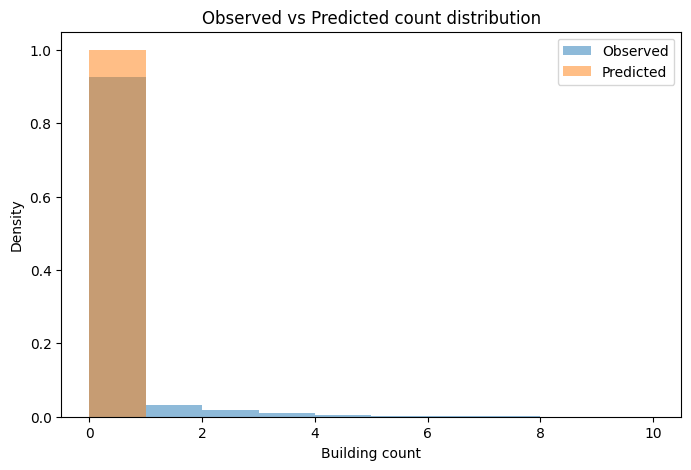

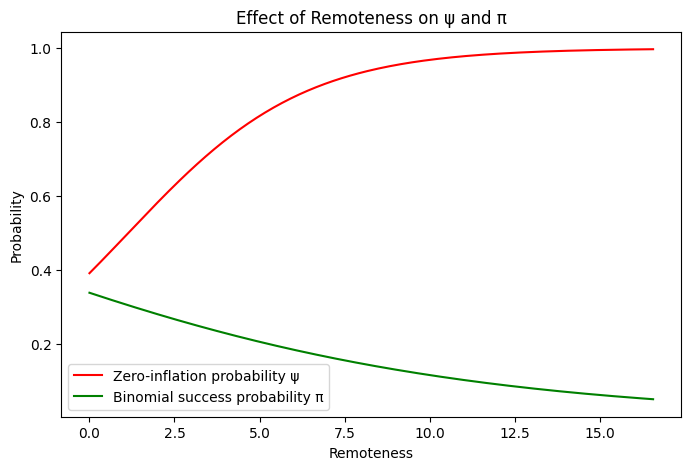

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# ÊèêÂèñÊ†∑Êú¨
X_all = df_16[['remoteness']].values
y_all = df_16['building_count'].values

# Log-likelihood
neg_loglik = model.result.fun
print("Negative log-likelihood:", neg_loglik)

# È¢ÑÊµãÈõ∂ÊØî‰æã vs ÂÆûÈôÖÈõ∂ÊØî‰æã
probs_all, psi_all, p_all = model.predict_proba(X_all)
pred_zero_prob = np.mean(probs_all[:, 0])
obs_zero_prob = np.mean(y_all == 0)
print("Observed zero proportion:", obs_zero_prob)
print("Predicted zero proportion:", pred_zero_prob)

# È¢ÑÊµãÊúüÊúõÂÄº & MSE/MAE
y_pred = model.predict(X_all)
mse = np.mean((y_all - y_pred)**2)
mae = np.mean(np.abs(y_all - y_pred))
print("MSE:", mse, "MAE:", mae)

# Áõ¥ÊñπÂõæÂØπÊØî
plt.figure(figsize=(8,5))
plt.hist(y_all, bins=range(model.n_trials+2), alpha=0.5, label='Observed', density=True)
plt.hist(np.argmax(probs_all, axis=1), bins=range(model.n_trials+2), alpha=0.5, label='Predicted', density=True)
plt.xlabel("Building count")
plt.ylabel("Density")
plt.legend()
plt.title("Observed vs Predicted count distribution")
plt.show()

# Remoteness ÂØπ œà Âíå œÄ ÁöÑÂΩ±Âìç
x_grid = np.linspace(X_all.min(), X_all.max(), 200).reshape(-1,1)
probs_grid, psi_grid, p_grid = model.predict_proba(x_grid)

plt.figure(figsize=(8,5))
plt.plot(x_grid, psi_grid, label='Zero-inflation probability œà', color='red')
plt.plot(x_grid, p_grid, label='Binomial success probability œÄ', color='green')
plt.xlabel("Remoteness")
plt.ylabel("Probability")
plt.legend()
plt.title("Effect of Remoteness on œà and œÄ")
plt.show()

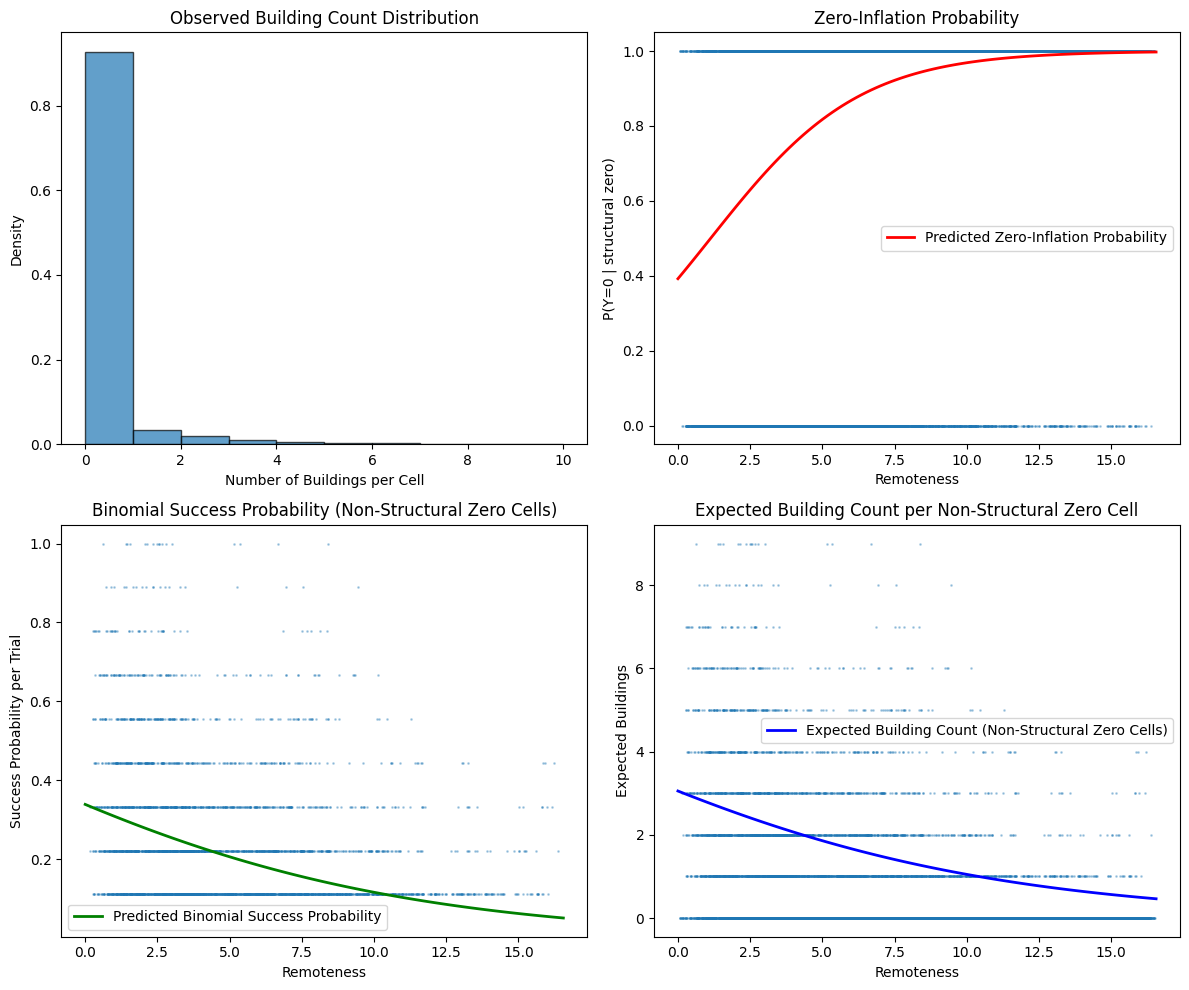

In [5]:
model.plot_fit(df_16['remoteness'], df_16['building_count'], 'Remoteness',sample_size=50000)

### Mumbai

In [31]:
print(max(df_16_mumbai['remoteness']))
print(max(df_16['remoteness']))

6.219726158957382
16.555315441362353


In [14]:
import time
from tqdm import tqdm

model2 = ZeroInflatedBinomial(n_trials=9)

start = time.time()
result2 = model2.fit(df_16_mumbai[['remoteness']], df_16_mumbai['building_count'], maxiter=200)
end = time.time()

print(f"ÊÄªËÄóÊó∂: {end - start:.2f} Áßí")

ÂºÄÂßãÊãüÂêàÊ®°Âûã... Ê†∑Êú¨Êï∞: 15996000, ÁâπÂæÅÊï∞: 1
Èõ∂ÂÄºÊØî‰æã: 0.917
ÂàùÂßãzero-inflationÊ¶ÇÁéá: 0.990
ÂàùÂßãbinomialÊ¶ÇÁéá: 0.387


‰ºòÂåñËøõÂ∫¶:   5%|‚ñà‚ñå                              | 10/200 [01:47<33:58, 10.73s/it]


‰ºòÂåñÂÆåÊàê. Ë¥üÂØπÊï∞‰ººÁÑ∂: 7615036.5686
scaler mean, scale: [3.36518499] [1.25432244]
ÊÄªËÄóÊó∂: 150.30 Áßí


In [16]:
params_orig = unscale_params(model2)
print("Unscaled params (alpha_zi, beta_zi, alpha_bin, beta_bin):", params_orig)

Unscaled params (alpha_zi, beta_zi, alpha_bin, beta_bin): [ 1.2354991   0.3705028  -0.42621956 -0.02023301]


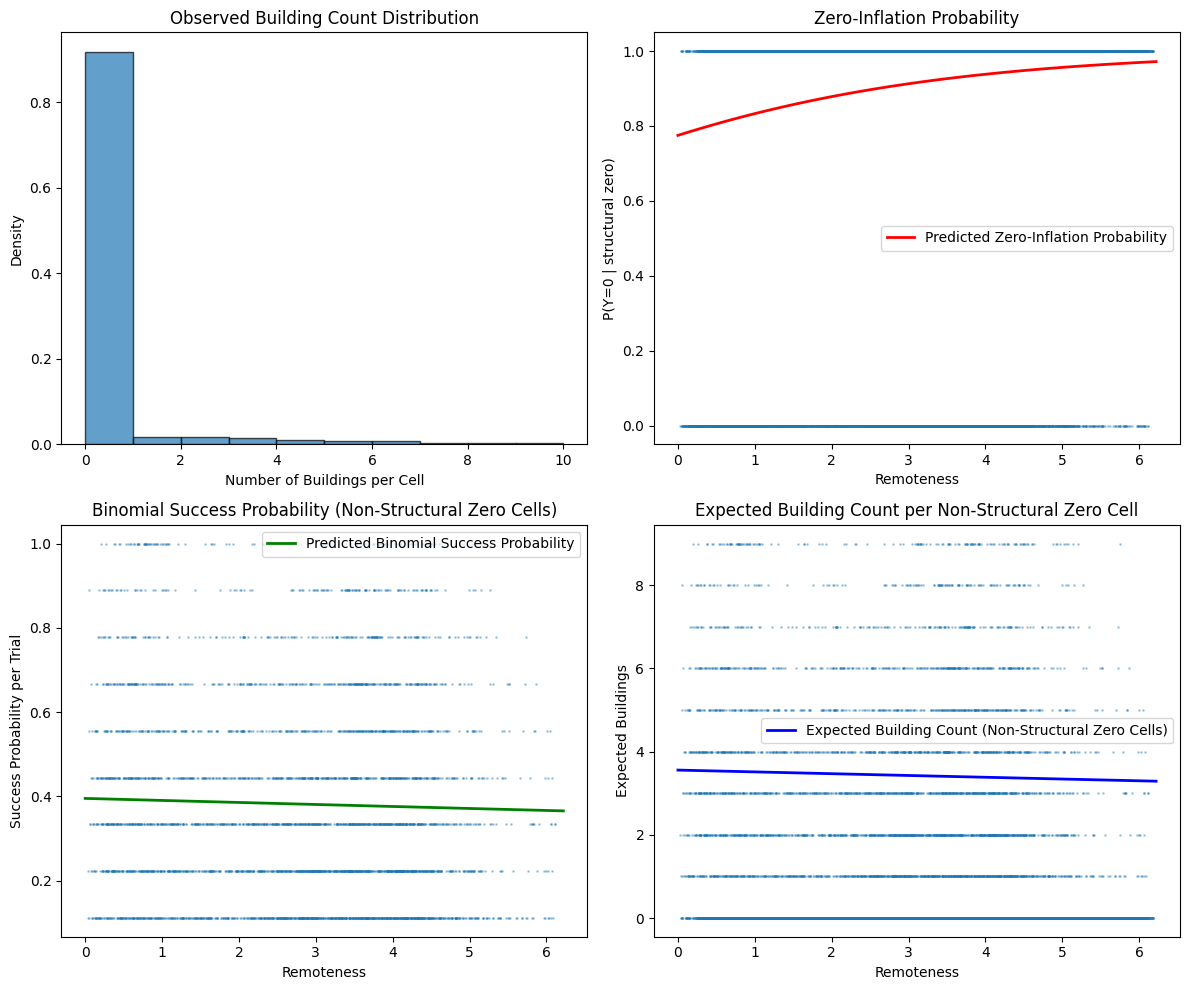

In [23]:
model2.plot_fit(df_16_mumbai['remoteness'], df_16_mumbai['building_count'], 'Remoteness',sample_size=50000)

In [24]:
print(result2.params)

[ 2.4823097   0.46473082 -0.49430747 -0.02537826]


Negative log-likelihood: 7615036.568606862
Observed zero proportion: 0.9172771317829458
Predicted zero proportion: 0.9172792952655239
MSE: 1.304752081818466 MAE: 0.516951802211399


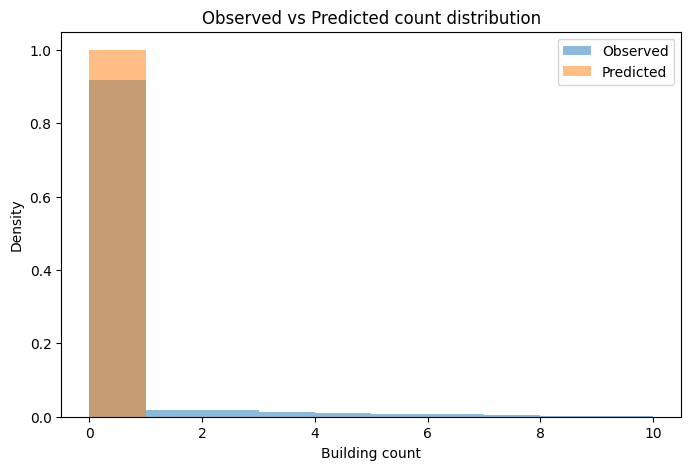

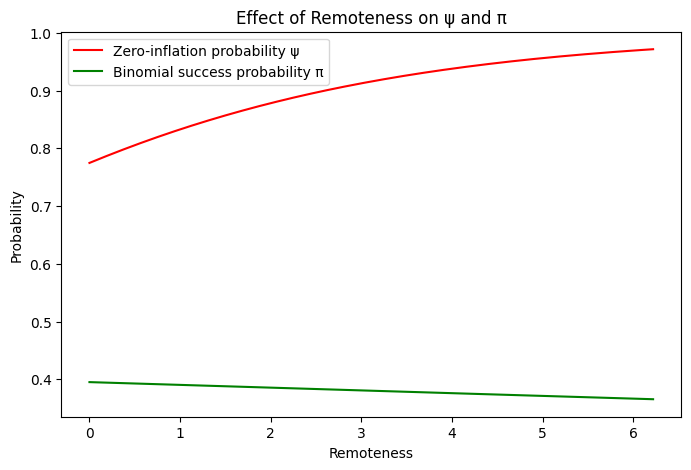

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# ÊèêÂèñÊ†∑Êú¨
X_all = df_16_mumbai[['remoteness']].values
y_all = df_16_mumbai['building_count'].values

# Log-likelihood
neg_loglik = model2.result.fun
print("Negative log-likelihood:", neg_loglik)

# È¢ÑÊµãÈõ∂ÊØî‰æã vs ÂÆûÈôÖÈõ∂ÊØî‰æã
probs_all, psi_all, p_all = model2.predict_proba(X_all)
pred_zero_prob = np.mean(probs_all[:, 0])
obs_zero_prob = np.mean(y_all == 0)
print("Observed zero proportion:", obs_zero_prob)
print("Predicted zero proportion:", pred_zero_prob)

# È¢ÑÊµãÊúüÊúõÂÄº & MSE/MAE
y_pred = model2.predict(X_all)
mse = np.mean((y_all - y_pred)**2)
mae = np.mean(np.abs(y_all - y_pred))
print("MSE:", mse, "MAE:", mae)

# Áõ¥ÊñπÂõæÂØπÊØî
plt.figure(figsize=(8,5))
plt.hist(y_all, bins=range(model2.n_trials+2), alpha=0.5, label='Observed', density=True)
plt.hist(np.argmax(probs_all, axis=1), bins=range(model2.n_trials+2), alpha=0.5, label='Predicted', density=True)
plt.xlabel("Building count")
plt.ylabel("Density")
plt.legend()
plt.title("Observed vs Predicted count distribution")
plt.show()

# Remoteness ÂØπ œà Âíå œÄ ÁöÑÂΩ±Âìç
x_grid = np.linspace(X_all.min(), X_all.max(), 200).reshape(-1,1)
probs_grid, psi_grid, p_grid = model2.predict_proba(x_grid)

plt.figure(figsize=(8,5))
plt.plot(x_grid, psi_grid, label='Zero-inflation probability œà', color='red')
plt.plot(x_grid, p_grid, label='Binomial success probability œÄ', color='green')
plt.xlabel("Remoteness")
plt.ylabel("Probability")
plt.legend()
plt.title("Effect of Remoteness on œà and œÄ")
plt.show()

### Mexico City

In [18]:
import time
from tqdm import tqdm

model3 = ZeroInflatedBinomial(n_trials=9)

start = time.time()
result3 = model3.fit(df_16_mexico[['remoteness']], df_16_mexico['building_count'], maxiter=200)
end = time.time()

print(f"ÊÄªËÄóÊó∂: {end - start:.2f} Áßí")

ÂºÄÂßãÊãüÂêàÊ®°Âûã... Ê†∑Êú¨Êï∞: 15996000, ÁâπÂæÅÊï∞: 1
Èõ∂ÂÄºÊØî‰æã: 0.476
ÂàùÂßãzero-inflationÊ¶ÇÁéá: 0.571
ÂàùÂßãbinomialÊ¶ÇÁéá: 0.435


‰ºòÂåñËøõÂ∫¶:   4%|‚ñà‚ñç                               | 9/200 [01:40<35:39, 11.20s/it]


‰ºòÂåñÂÆåÊàê. Ë¥üÂØπÊï∞‰ººÁÑ∂: 30141505.7256
scaler mean, scale: [3.20936438] [1.19639818]
ÊÄªËÄóÊó∂: 148.80 Áßí


In [20]:
params_orig = unscale_params(model3)
print("Unscaled params (alpha_zi, beta_zi, alpha_bin, beta_bin):", params_orig)

Unscaled params (alpha_zi, beta_zi, alpha_bin, beta_bin): [-1.84094514  0.53334158  0.21447513 -0.17171822]


Negative log-likelihood: 30141505.725591343
Observed zero proportion: 0.47609939984996247
Predicted zero proportion: 0.4761015865798281
MSE: 5.729514686387056 MAE: 1.966124239784908


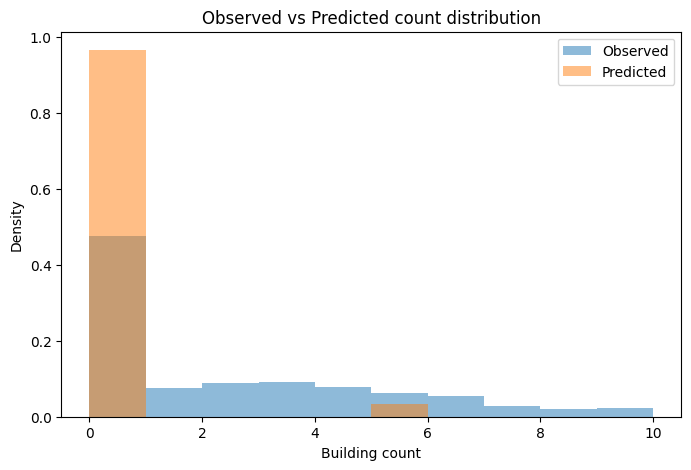

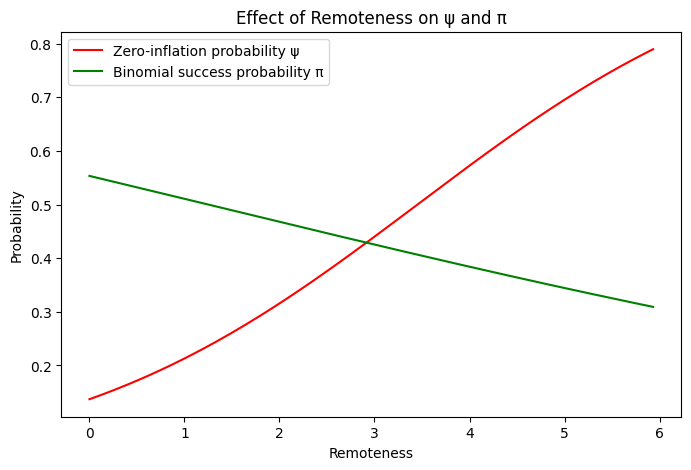

In [35]:
import numpy as np
import matplotlib.pyplot as plt

# ÊèêÂèñÊ†∑Êú¨
X_all = df_16_mexico[['remoteness']].values
y_all = df_16_mexico['building_count'].values

# Log-likelihood
neg_loglik = model3.result.fun
print("Negative log-likelihood:", neg_loglik)

# È¢ÑÊµãÈõ∂ÊØî‰æã vs ÂÆûÈôÖÈõ∂ÊØî‰æã
probs_all, psi_all, p_all = model3.predict_proba(X_all)
pred_zero_prob = np.mean(probs_all[:, 0])
obs_zero_prob = np.mean(y_all == 0)
print("Observed zero proportion:", obs_zero_prob)
print("Predicted zero proportion:", pred_zero_prob)

# È¢ÑÊµãÊúüÊúõÂÄº & MSE/MAE
y_pred = model3.predict(X_all)
mse = np.mean((y_all - y_pred)**2)
mae = np.mean(np.abs(y_all - y_pred))
print("MSE:", mse, "MAE:", mae)

# Áõ¥ÊñπÂõæÂØπÊØî
plt.figure(figsize=(8,5))
plt.hist(y_all, bins=range(model3.n_trials+2), alpha=0.5, label='Observed', density=True)
plt.hist(np.argmax(probs_all, axis=1), bins=range(model3.n_trials+2), alpha=0.5, label='Predicted', density=True)
plt.xlabel("Building count")
plt.ylabel("Density")
plt.legend()
plt.title("Observed vs Predicted count distribution")
plt.show()

# Remoteness ÂØπ œà Âíå œÄ ÁöÑÂΩ±Âìç
x_grid = np.linspace(X_all.min(), X_all.max(), 200).reshape(-1,1)
probs_grid, psi_grid, p_grid = model3.predict_proba(x_grid)

plt.figure(figsize=(8,5))
plt.plot(x_grid, psi_grid, label='Zero-inflation probability œà', color='red')
plt.plot(x_grid, p_grid, label='Binomial success probability œÄ', color='green')
plt.xlabel("Remoteness")
plt.ylabel("Probability")
plt.legend()
plt.title("Effect of Remoteness on œà and œÄ")
plt.show()

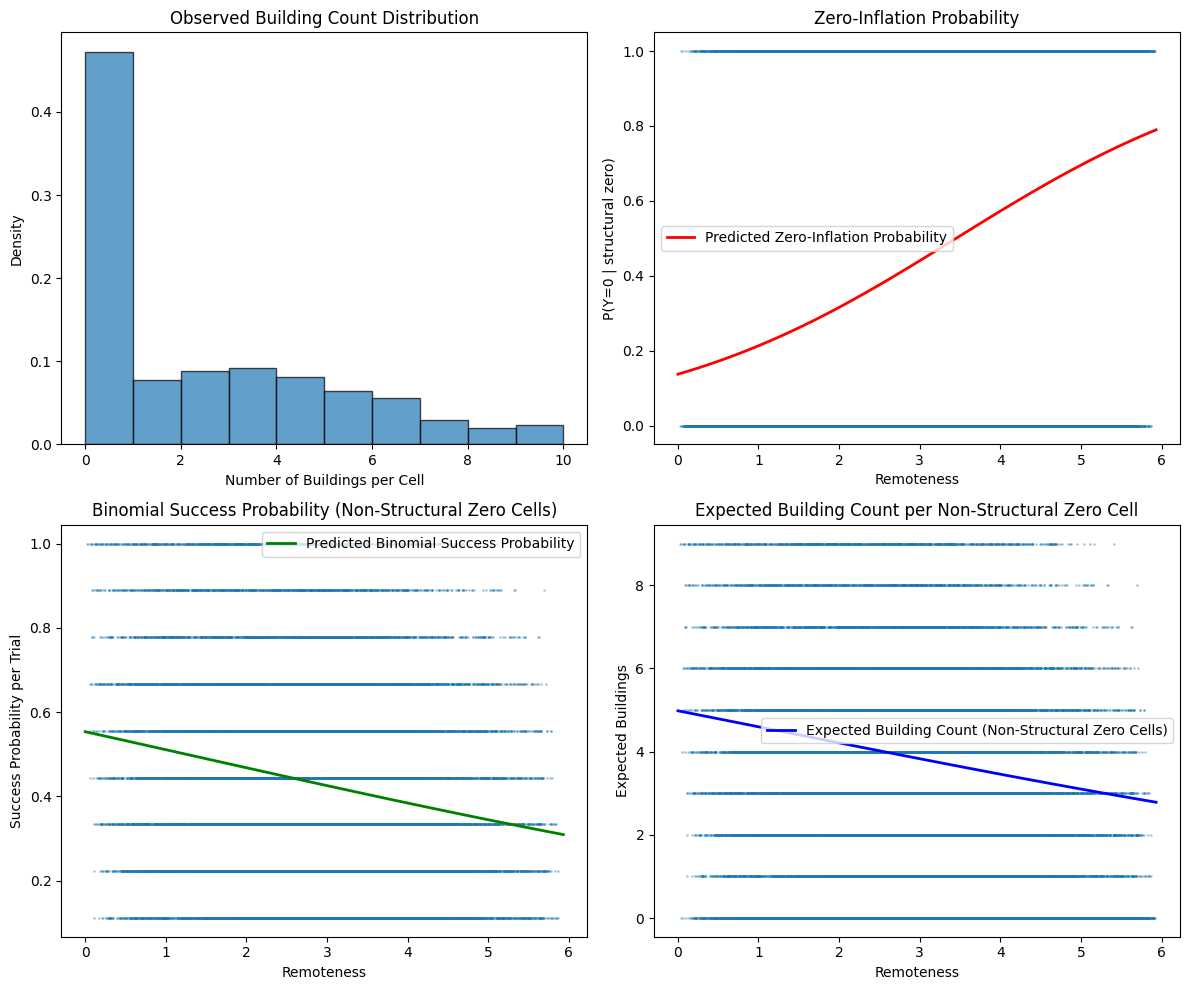

In [34]:
model3.plot_fit(df_16_mexico['remoteness'], df_16_mexico['building_count'], 'Remoteness',sample_size=50000)

## ÊØîËæÉ‰∏çÂêåpackageÁöÑ‰ºòÂåñÁªìÊûú

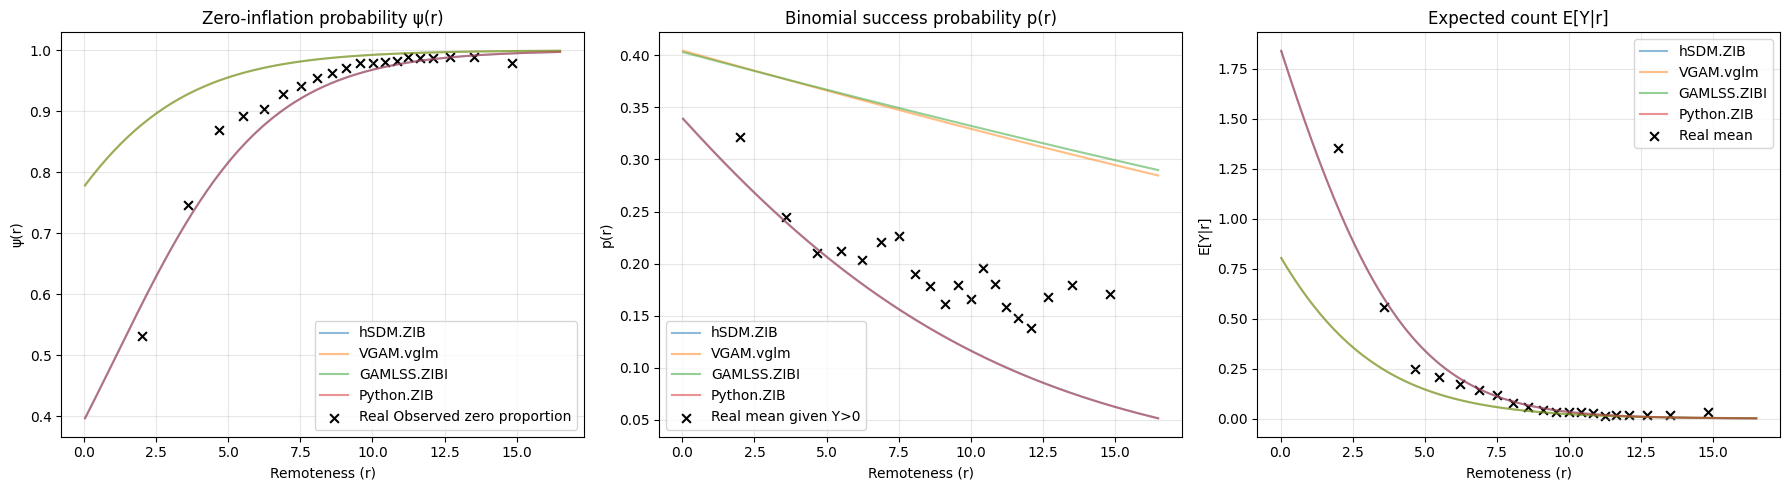

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import expit

# ---------- ËßÇÊµãÊï∞ÊçÆÁöÑÂàÜÁÆ±ÁªüËÆ° ----------
def empirical_points(df, n_bins=20):
    df = df.copy()
    df["bin"] = pd.qcut(df["remoteness"], n_bins, duplicates="drop")
    grouped = df.groupby("bin")

    r_mid = grouped["remoteness"].mean()
    zero_prob = grouped["building_count"].apply(lambda x: np.mean(x == 0))
    nonzero_mean = grouped["building_count"].apply(lambda x: x[x>0].mean()/9 if np.any(x>0) else np.nan)
    overall_mean = grouped["building_count"].mean()

    return r_mid, zero_prob, nonzero_mean, overall_mean

r_mid, zero_prob, nonzero_mean, overall_mean = empirical_points(df_16_sample, n_bins=20)

# ---------- ÂèÇÊï∞Â≠óÂÖ∏ ----------
params = {
    "hSDM.ZIB":   {"alpha_zi": -0.426, "beta_zi":  0.384,  "alpha_bin": -0.664, "beta_bin": -0.136},
    "VGAM.vglm":  {"alpha_zi":  1.253, "beta_zi":  0.363,  "alpha_bin": -0.387, "beta_bin": -0.0324},
    "GAMLSS.ZIBI":{"alpha_zi":  1.248, "beta_zi":  0.365,  "alpha_bin": -0.393, "beta_bin": -0.0305},
    "Python.ZIB": {"alpha_zi": -0.427, "beta_zi":  0.384,  "alpha_bin": -0.666, "beta_bin": -0.136}
}

n_trials = 9
r = np.linspace(df_16_sample["remoteness"].min(), df_16_sample["remoteness"].max(), 200)

# ---------- ÁîªÂõæ ----------
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for method, par in params.items():
    psi = expit(par["alpha_zi"] + par["beta_zi"] * r)
    p   = expit(par["alpha_bin"] + par["beta_bin"] * r)
    expected = (1 - psi) * n_trials * p
    
    axes[0].plot(r, psi, label=method,alpha=0.5)
    axes[1].plot(r, p, label=method,alpha=0.5)
    axes[2].plot(r, expected, label=method,alpha=0.5)

# Âä†ÂÖ•ËßÇÊµãÁÇπ
axes[0].scatter(r_mid, zero_prob, c="black", s=40, marker="x", label="Real Observed zero proportion")
axes[1].scatter(r_mid, nonzero_mean, c="black", s=40, marker="x", label="Real mean given Y>0")
axes[2].scatter(r_mid, overall_mean, c="black", s=40, marker="x", label="Real mean")

# ËÆæÁΩÆÊ†áÈ¢òÂíåÂõæ‰æã
axes[0].set_title("Zero-inflation probability œà(r)")
axes[0].set_xlabel("Remoteness (r)")
axes[0].set_ylabel("œà(r)")

axes[1].set_title("Binomial success probability p(r)")
axes[1].set_xlabel("Remoteness (r)")
axes[1].set_ylabel("p(r)")

axes[2].set_title("Expected count E[Y|r]")
axes[2].set_xlabel("Remoteness (r)")
axes[2].set_ylabel("E[Y|r]")

for ax in axes:
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## ÊâπÈáèÂ§ÑÁêÜ

In [3]:
import pandas as pd
import numpy as np
import time
import os
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.special import expit
import warnings
warnings.filterwarnings('ignore')

def unscale_params(model):
    """
    Â∞ÜÊ†áÂáÜÂåñÂêéÁöÑÂèÇÊï∞ËΩ¨Êç¢ÂõûÂéüÂßãÂ∞∫Â∫¶
    
    Ê†áÂáÜÂåñÊ®°Âûã: logit(psi) = alpha_zi_std + beta_zi_std * X_std
    ÂÖ∂‰∏≠ X_std = (X - mean) / std
    
    ÂéüÂßãÂ∞∫Â∫¶: logit(psi) = alpha_zi + beta_zi * X
    
    ÂÖ≥Á≥ª:
    beta_zi = beta_zi_std / std
    alpha_zi = alpha_zi_std - beta_zi_std * mean / std
    """
    params_std = model.params
    remoteness_mean = model.scaler.mean_[0]
    remoteness_std = model.scaler.scale_[0]
    
    # Ê†áÂáÜÂåñÂèÇÊï∞
    alpha_zi_std = params_std[0]
    beta_zi_std = params_std[1]
    alpha_bin_std = params_std[2]
    beta_bin_std = params_std[3]
    
    # ËΩ¨Êç¢Âà∞ÂéüÂßãÂ∞∫Â∫¶
    beta_zi = beta_zi_std / remoteness_std
    alpha_zi = alpha_zi_std - beta_zi_std * remoteness_mean / remoteness_std
    
    beta_bin = beta_bin_std / remoteness_std
    alpha_bin = alpha_bin_std - beta_bin_std * remoteness_mean / remoteness_std
    
    return alpha_zi, beta_zi, alpha_bin, beta_bin


def fit_zib_cities(city_list, years=[2016, 2023], folder='aggregated_data', 
                   maxiter=1000, method='L-BFGS-B', save_diagnostics=True,
                   output_file='zib_fitting_results.csv', resume=True):
    """
    ÊâπÈáèÊãüÂêàÂ§ö‰∏™ÂüéÂ∏ÇÂ§ö‰∏™Âπ¥‰ªΩÁöÑZero-Inflated BinomialÊ®°Âûã
    
    ÂèÇÊï∞:
    ------
    city_list : list
        ÂüéÂ∏ÇÂêçÁß∞ÂàóË°®
    years : list
        Âπ¥‰ªΩÂàóË°®
    folder : str
        Êï∞ÊçÆÊñá‰ª∂Â§πË∑ØÂæÑ
    maxiter : int
        ÊúÄÂ§ßËø≠‰ª£Ê¨°Êï∞
    method : str
        ‰ºòÂåñÊñπÊ≥ï ('L-BFGS-B', 'BFGS', 'Newton-CG')
    save_diagnostics : bool
        ÊòØÂê¶‰øùÂ≠òËØ¶ÁªÜËØäÊñ≠‰ø°ÊÅØ
    output_file : str
        ËæìÂá∫CSVÊñá‰ª∂ÂêçÔºàÂ¢ûÈáè‰øùÂ≠òÔºâ
    resume : bool
        ÊòØÂê¶‰ªé‰∏äÊ¨°‰∏≠Êñ≠Â§ÑÁªßÁª≠ÔºàË∑≥ËøáÂ∑≤ÂÆåÊàêÁöÑÂüéÂ∏Ç-Âπ¥‰ªΩÔºâ
        
    ËøîÂõû:
    ------
    df_results : DataFrame
        ÂåÖÂê´ÊâÄÊúâÊãüÂêàÁªìÊûúÁöÑÊï∞ÊçÆÊ°Ü
    diagnostics : dict (optional)
        ËØ¶ÁªÜËØäÊñ≠‰ø°ÊÅØÂ≠óÂÖ∏
    """
    results = []
    diagnostics = {}
    
    # Ê£ÄÊü•ÊòØÂê¶Â≠òÂú®Â∑≤ÊúâÁªìÊûúÔºàÊñ≠ÁÇπÁª≠‰º†Ôºâ
    completed_set = set()
    if resume and os.path.exists(output_file):
        try:
            existing_results = pd.read_csv(output_file)
            completed_set = set(zip(existing_results['city'], existing_results['year']))
            results = existing_results.to_dict('records')
            print(f"üìÇ ÂèëÁé∞Â∑≤ÊúâÁªìÊûúÊñá‰ª∂: {output_file}")
            print(f"‚úì Â∑≤ÂÆåÊàê {len(completed_set)} ‰∏™‰ªªÂä°ÔºåÂ∞ÜÁªßÁª≠Êú™ÂÆåÊàêÁöÑ‰ªªÂä°")
            print("=" * 80)
        except Exception as e:
            print(f"‚ö†Ô∏è  ËØªÂèñÂ∑≤ÊúâÁªìÊûúÂ§±Ë¥•: {e}")
            print("Â∞Ü‰ªéÂ§¥ÂºÄÂßãÊãüÂêà")
            completed_set = set()
    
    # ËØªÂèñÂüéÂ∏ÇÊï∞ÊçÆÂ∫ì
    try:
        cities = pd.read_csv("CitiesDB_new.csv")
    except FileNotFoundError:
        print("ÈîôËØØ: CitiesDB_new.csv Êñá‰ª∂Êú™ÊâæÂà∞")
        return None
    
    print(f"ÂºÄÂßãÊâπÈáèÊãüÂêà {len(city_list)} ‰∏™ÂüéÂ∏ÇÔºå{len(years)} ‰∏™Âπ¥‰ªΩ")
    print(f"‰ºòÂåñÊñπÊ≥ï: {method}, ÊúÄÂ§ßËø≠‰ª£Ê¨°Êï∞: {maxiter}")
    print("=" * 80)
    
    # ‰ΩøÁî®tqdmÊòæÁ§∫ÊÄªËøõÂ∫¶
    total_tasks = len(city_list) * len(years)
    pbar = tqdm(total=total_tasks, desc="ÊÄªËøõÂ∫¶")
    
    for year in years:
        for city in city_list:
            # Ê£ÄÊü•ÊòØÂê¶Â∑≤ÂÆåÊàê
            if (city, year) in completed_set:
                print(f"‚è≠Ô∏è  Ë∑≥ËøáÂ∑≤ÂÆåÊàê: {city} {year}")
                pbar.update(1)
                continue
            
            city_year_key = f"{city}_{year}"
            file_path = f"{folder}/{city}_{year}_3x3_windows.csv"
            
            try:
                # ËØªÂèñÊï∞ÊçÆ
                df = pd.read_csv(file_path)
                n_obs = len(df)
                
                # Ëé∑Âèñ‰∫∫Âè£
                pop_col = f'pop_{year}_UN'
                if pop_col not in cities.columns:
                    print(f"\n‚ö†Ô∏è  {city} {year}: ‰∫∫Âè£Âàó {pop_col} ‰∏çÂ≠òÂú®ÔºåË∑≥Ëøá")
                    pbar.update(1)
                    continue
                
                pop = cities.loc[cities['Name'] == city, pop_col].iloc[0] * 1000
                
                # ËÆ°ÁÆó remoteness
                df['remoteness'] = (df['distance_to_center'] / np.sqrt(pop)) * 1000
                df['bd'] = 9
                
                # Êï∞ÊçÆÊëòË¶ÅÁªüËÆ°
                zero_ratio = (df['building_count'] == 0).mean()
                mean_nonzero = df.loc[df['building_count'] > 0, 'building_count'].mean() if (df['building_count'] > 0).any() else 0
                remoteness_mean = df['remoteness'].mean()
                remoteness_std = df['remoteness'].std()
                remoteness_min = df['remoteness'].min()
                remoteness_max = df['remoteness'].max()
                
                # ÊãüÂêàÊ®°Âûã
                model = ZeroInflatedBinomial(n_trials=9)
                start = time.time()
                
                try:
                    model.fit(
                        df[['remoteness']], 
                        df['building_count'], 
                        method=method,
                        maxiter=maxiter
                    )
                    
                    # ‰ªémodel.resultËé∑Âèñ‰ºòÂåñÁªìÊûú
                    result = model.result
                    fit_success = result.success
                    fit_message = result.message
                    n_iterations = result.nit
                    
                except Exception as e:
                    print(f"\n‚ùå {city} {year}: ÊãüÂêàÂ§±Ë¥• - {str(e)}")
                    pbar.update(1)
                    continue
                
                end = time.time()
                fit_time = end - start
                
                # Unscale ÂèÇÊï∞Âà∞ÂéüÂßãÂ∞∫Â∫¶
                alpha_zi, beta_zi, alpha_bin, beta_bin = unscale_params(model)
                
                # ËÆ°ÁÆó‰∏≠ÂøÉÁÇπÔºàremoteness=0ÔºâÁöÑÊ¶ÇÁéá
                psi_center = expit(alpha_zi)      # zero-inflationÊ¶ÇÁéáÂú®‰∏≠ÂøÉ
                pi_center = expit(alpha_bin)      # binomialÊàêÂäüÊ¶ÇÁéáÂú®‰∏≠ÂøÉ
                
                # ËÆ°ÁÆóÂπ≥ÂùáremotenessÂ§ÑÁöÑÊ¶ÇÁéáÔºàÊõ¥ÊúâÂÆûÈôÖÊÑè‰πâÔºâ
                psi_mean = expit(alpha_zi + beta_zi * remoteness_mean)
                pi_mean = expit(alpha_bin + beta_bin * remoteness_mean)
                
                # Ê®°ÂûãÊãüÂêàÁªüËÆ°Èáè
                loglik = -result.fun
                k = 4  # ÂèÇÊï∞‰∏™Êï∞
                n = len(df)
                aic = 2 * k - 2 * loglik
                bic = k * np.log(n) - 2 * loglik
                
                # È¢ÑÊµã‰∏éÊÆãÂ∑Æ
                preds = model.predict(df[['remoteness']])
                residuals = df['building_count'] - preds
                mse = mean_squared_error(df['building_count'], preds)
                rmse = np.sqrt(mse)
                mae = mean_absolute_error(df['building_count'], preds)
                
                # È¢ÑÊµãÈõ∂ÂÄºÊØî‰æã
                pred_probs, pred_psi, pred_pi = model.predict_proba(df[['remoteness']])
                pred_zero_ratio = pred_probs[:, 0].mean()
                
                # ‰º™RÊñπ (McFadden's R-squared)
                # Èõ∂Ê®°Âûã: Âè™ÊúâÊà™Ë∑ù
                null_loglik = n * zero_ratio * np.log(zero_ratio + 1e-10) + \
                             n * (1 - zero_ratio) * np.log(1 - zero_ratio + 1e-10)
                pseudo_r2 = 1 - (loglik / null_loglik) if null_loglik != 0 else np.nan
                
                # Êî∂ÈõÜÁªìÊûú
                result_dict = {
                    'city': city,
                    'year': year,
                    'n_obs': n_obs,
                    'population': pop,
                    
                    # ÂéüÂßãÂ∞∫Â∫¶ÂèÇÊï∞
                    'alpha_zi': alpha_zi,
                    'beta_zi': beta_zi,
                    'alpha_bin': alpha_bin,
                    'beta_bin': beta_bin,
                    
                    # ‰∏≠ÂøÉÁÇπÊ¶ÇÁéáÔºàremoteness=0Ôºâ
                    'psi_at_center': psi_center,
                    'pi_at_center': pi_center,
                    
                    # Âπ≥ÂùáremotenessÂ§ÑÁöÑÊ¶ÇÁéáÔºàÊõ¥ÊúâÊÑè‰πâÔºâ
                    'psi_at_mean': psi_mean,
                    'pi_at_mean': pi_mean,
                    
                    # Êï∞ÊçÆÁªüËÆ°
                    'zero_ratio_obs': zero_ratio,
                    'zero_ratio_pred': pred_zero_ratio,
                    'mean_nonzero_count': mean_nonzero,
                    'remoteness_mean': remoteness_mean,
                    'remoteness_std': remoteness_std,
                    'remoteness_range': remoteness_max - remoteness_min,
                    
                    # Ê®°ÂûãÊãüÂêàÊåáÊ†á
                    'logLik': loglik,
                    'AIC': aic,
                    'BIC': bic,
                    'pseudo_R2': pseudo_r2,
                    
                    # È¢ÑÊµãËØØÂ∑Æ
                    'MSE': mse,
                    'RMSE': rmse,
                    'MAE': mae,
                    
                    # ÊãüÂêà‰ø°ÊÅØ
                    'fit_time_sec': fit_time,
                    'n_iterations': n_iterations,
                    'convergence': fit_success,
                    'fit_message': fit_message
                }
                
                results.append(result_dict)
                
                # üî• Á´ãÂç≥‰øùÂ≠òÂà∞CSVÔºàÂ¢ûÈáè‰øùÂ≠òÔºâ
                df_temp = pd.DataFrame(results)
                df_temp.to_csv(output_file, index=False)
                
                # ‰øùÂ≠òËØ¶ÁªÜËØäÊñ≠
                if save_diagnostics:
                    diagnostics[city_year_key] = {
                        'model': model,
                        'result': result,
                        'predictions': preds,
                        'residuals': residuals,
                        'data': df[['remoteness', 'building_count']].copy()
                    }
                
                # ÊâìÂç∞ËøõÂ∫¶‰ø°ÊÅØ
                status = "‚úì" if fit_success else "‚ö†"
                pbar.set_postfix({
                    'city': city, 
                    'year': year, 
                    'time': f"{fit_time:.1f}s",
                    'iter': n_iterations,
                    'status': status
                })
                
            except FileNotFoundError:
                print(f"\n‚ö†Ô∏è  Êñá‰ª∂Êú™ÊâæÂà∞: {file_path}")
            except Exception as e:
                print(f"\n‚ùå {city} {year}: Â§ÑÁêÜÂ§±Ë¥• - {str(e)}")
            
            pbar.update(1)
    
    pbar.close()
    
    # ËΩ¨Êç¢‰∏∫DataFrame
    df_results = pd.DataFrame(results)
    
    if len(df_results) == 0:
        print("\n‚ùå Ê≤°ÊúâÊàêÂäüÊãüÂêà‰ªª‰ΩïÊ®°Âûã")
        return None
    
    # ÊâìÂç∞Ê±áÊÄªÁªüËÆ°
    print("\n" + "=" * 80)
    print("ÊãüÂêàÂÆåÊàêÊ±áÊÄª:")
    print(f"ÊàêÂäüÊãüÂêà: {len(df_results)} / {total_tasks}")
    if len(df_results) > 0:
        print(f"Âπ≥ÂùáÊãüÂêàÊó∂Èó¥: {df_results['fit_time_sec'].mean():.2f} Áßí")
        print(f"Âπ≥ÂùáËø≠‰ª£Ê¨°Êï∞: {df_results['n_iterations'].mean():.1f}")
        print(f"Êî∂ÊïõÊàêÂäüÁéá: {df_results['convergence'].mean():.1%}")
    print(f"‚úì ÁªìÊûúÂ∑≤‰øùÂ≠òÂà∞: {output_file}")
    print("=" * 80)
    
    # ÊâìÂç∞ÂèÇÊï∞Ê±áÊÄª
    print("\nÂèÇÊï∞‰º∞ËÆ°Ê±áÊÄªÔºàÂéüÂßãÂ∞∫Â∫¶Ôºâ:")
    print(df_results[['city', 'year', 'alpha_zi', 'beta_zi', 'alpha_bin', 'beta_bin']].to_string())
    
    print("\nÊ®°ÂûãÊãüÂêàË¥®Èáè:")
    print(df_results[['city', 'year', 'AIC', 'BIC', 'pseudo_R2', 'MAE']].to_string())
    
    print("\nZero-inflationÁªüËÆ°:")
    print(df_results[['city', 'year', 'zero_ratio_obs', 'zero_ratio_pred', 'psi_at_mean']].to_string())
    
    if save_diagnostics:
        return df_results, diagnostics
    else:
        return df_results


def compare_years(df_results, metric='beta_zi'):
    """
    ÊØîËæÉÂêå‰∏ÄÂüéÂ∏Ç‰∏çÂêåÂπ¥‰ªΩÁöÑÂèÇÊï∞ÂèòÂåñ
    
    ÂèÇÊï∞:
    ------
    df_results : DataFrame
        fit_zib_citiesÁöÑËøîÂõûÁªìÊûú
    metric : str
        Ë¶ÅÊØîËæÉÁöÑÊåáÊ†áÂàóÂêç
    """
    if len(df_results) == 0:
        print("Ê≤°ÊúâÊï∞ÊçÆÂèØÊØîËæÉ")
        return
    
    cities = df_results['city'].unique()
    
    print(f"\n{metric} Âπ¥ÈôÖÂèòÂåñÂàÜÊûê:")
    print("=" * 60)
    
    for city in cities:
        city_data = df_results[df_results['city'] == city].sort_values('year')
        if len(city_data) < 2:
            continue
        
        years = city_data['year'].values
        values = city_data[metric].values
        change = values[-1] - values[0]
        pct_change = (change / values[0] * 100) if values[0] != 0 else np.nan
        
        print(f"{city}:")
        for year, value in zip(years, values):
            print(f"  {year}: {value:.4f}")
        print(f"  ÂèòÂåñ: {change:+.4f} ({pct_change:+.1f}%)")
        print()


def plot_city_comparison(df_results, diagnostics, city_list, year=2016):
    """
    ÂèØËßÜÂåñÊØîËæÉÂ§ö‰∏™ÂüéÂ∏ÇÁöÑÊãüÂêàÁªìÊûú
    """
    import matplotlib.pyplot as plt
    
    n_cities = len(city_list)
    fig, axes = plt.subplots(2, n_cities, figsize=(5*n_cities, 10))
    
    if n_cities == 1:
        axes = axes.reshape(2, 1)
    
    for i, city in enumerate(city_list):
        key = f"{city}_{year}"
        if key not in diagnostics:
            print(f"Ë≠¶Âëä: {key} Ê≤°ÊúâËØäÊñ≠Êï∞ÊçÆ")
            continue
        
        diag = diagnostics[key]
        data = diag['data']
        preds = diag['predictions']
        
        # Êï£ÁÇπÂõæ
        axes[0, i].scatter(data['remoteness'], data['building_count'], 
                          alpha=0.3, s=1, label='ËßÇÊµãÂÄº')
        axes[0, i].scatter(data['remoteness'], preds, 
                          alpha=0.3, s=1, c='red', label='È¢ÑÊµãÂÄº')
        axes[0, i].set_xlabel('Remoteness')
        axes[0, i].set_ylabel('Building Count')
        axes[0, i].set_title(f"{city} {year}")
        axes[0, i].legend()
        
        # ÊÆãÂ∑ÆÂõæ
        residuals = diag['residuals']
        axes[1, i].scatter(data['remoteness'], residuals, alpha=0.3, s=1)
        axes[1, i].axhline(y=0, color='r', linestyle='--')
        axes[1, i].set_xlabel('Remoteness')
        axes[1, i].set_ylabel('Residuals')
        axes[1, i].set_title(f"Residuals - {city} {year}")
    
    plt.tight_layout()
    plt.show()




In [2]:
##ÁîüÊàêcitiesÂàóË°®
import pandas as pd
# ËØªÂèñ CSV Êñá‰ª∂
citiesDB = pd.read_csv("CitiesDB_new.csv")
subset = citiesDB.iloc[80:110]
cities = []
for _, row in subset.iterrows():
    city = row["Name"]
    cities.append(city)
# ÊâìÂç∞ÁªìÊûúÈ™åËØÅ
print(cities)

['Bogota', 'Guadalajara', 'Belo Horizonte', 'Brasilia', 'Guatemala City', 'Salvador', 'La Paz', 'Guayaquil', 'Santo Domingo', 'Medellin', 'Cali', 'Quito', 'Tegucigalpa', 'Leon', 'Puebla', 'San Jose', 'Managua', 'Port-au-Prince', 'Merida', 'Cancun', 'Queretaro', 'Acapulco', 'San Salvador', 'Asuncion']


In [4]:
# ‰ΩøÁî®Á§∫‰æã
if __name__ == "__main__":
    print("Zero-Inflated BinomialÊâπÈáèÊãüÂêàÂ∑•ÂÖ∑")
    print("=" * 80)
    
    # Á§∫‰æã1: Âü∫Êú¨‰ΩøÁî®ÔºàÂ∏¶Â¢ûÈáè‰øùÂ≠òÂíåÊñ≠ÁÇπÁª≠‰º†Ôºâ
    city_list = cities
    results_df = fit_zib_cities(
        city_list, 
        years=[2016, 2023],
        folder='aggregated_data',
        maxiter=100,
        output_file='zib_fitting_results.csv',  # ÊØèÂÆåÊàê‰∏Ä‰∏™Â∞±‰øùÂ≠ò
        resume=True  # ÊîØÊåÅÊñ≠ÁÇπÁª≠‰º†
    )
    
    # ÁªìÊûúÂ∑≤ÁªèËá™Âä®‰øùÂ≠òÔºåÊó†ÈúÄÊâãÂä®‰øùÂ≠ò
    print("\n‚úì ÊâÄÊúâÁªìÊûúÂ∑≤Â¢ûÈáè‰øùÂ≠òÂà∞: zib_fitting_results.csv")
    
    # Á§∫‰æã2: Â∏¶ËØäÊñ≠‰ø°ÊÅØ
    # results_df, diagnostics = fit_zib_cities(
    #     city_list, 
    #     years=[2016, 2023],
    #     save_diagnostics=True
    # )
    
    # Á§∫‰æã3: Âπ¥ÈôÖÊØîËæÉ
    # compare_years(results_df, metric='beta_zi')
    # compare_years(results_df, metric='zero_ratio_obs')
    
    # Á§∫‰æã4: ÂèØËßÜÂåñ
    # plot_city_comparison(results_df, diagnostics, city_list, year=2016)

Zero-Inflated BinomialÊâπÈáèÊãüÂêàÂ∑•ÂÖ∑
üìÇ ÂèëÁé∞Â∑≤ÊúâÁªìÊûúÊñá‰ª∂: zib_fitting_results.csv
‚úì Â∑≤ÂÆåÊàê 193 ‰∏™‰ªªÂä°ÔºåÂ∞ÜÁªßÁª≠Êú™ÂÆåÊàêÁöÑ‰ªªÂä°
ÂºÄÂßãÊâπÈáèÊãüÂêà 24 ‰∏™ÂüéÂ∏ÇÔºå2 ‰∏™Âπ¥‰ªΩ
‰ºòÂåñÊñπÊ≥ï: L-BFGS-B, ÊúÄÂ§ßËø≠‰ª£Ê¨°Êï∞: 100


ÊÄªËøõÂ∫¶:   0%|                                            | 0/48 [00:00<?, ?it/s]

‚è≠Ô∏è  Ë∑≥ËøáÂ∑≤ÂÆåÊàê: Bogota 2016
‚è≠Ô∏è  Ë∑≥ËøáÂ∑≤ÂÆåÊàê: Guadalajara 2016
‚è≠Ô∏è  Ë∑≥ËøáÂ∑≤ÂÆåÊàê: Belo Horizonte 2016
‚è≠Ô∏è  Ë∑≥ËøáÂ∑≤ÂÆåÊàê: Brasilia 2016
‚è≠Ô∏è  Ë∑≥ËøáÂ∑≤ÂÆåÊàê: Guatemala City 2016
‚è≠Ô∏è  Ë∑≥ËøáÂ∑≤ÂÆåÊàê: Salvador 2016
‚è≠Ô∏è  Ë∑≥ËøáÂ∑≤ÂÆåÊàê: La Paz 2016
‚è≠Ô∏è  Ë∑≥ËøáÂ∑≤ÂÆåÊàê: Guayaquil 2016
‚è≠Ô∏è  Ë∑≥ËøáÂ∑≤ÂÆåÊàê: Santo Domingo 2016
‚è≠Ô∏è  Ë∑≥ËøáÂ∑≤ÂÆåÊàê: Medellin 2016
‚è≠Ô∏è  Ë∑≥ËøáÂ∑≤ÂÆåÊàê: Cali 2016
‚è≠Ô∏è  Ë∑≥ËøáÂ∑≤ÂÆåÊàê: Quito 2016
‚è≠Ô∏è  Ë∑≥ËøáÂ∑≤ÂÆåÊàê: Tegucigalpa 2016
‚è≠Ô∏è  Ë∑≥ËøáÂ∑≤ÂÆåÊàê: Leon 2016
‚è≠Ô∏è  Ë∑≥ËøáÂ∑≤ÂÆåÊàê: Puebla 2016
‚è≠Ô∏è  Ë∑≥ËøáÂ∑≤ÂÆåÊàê: San Jose 2016
‚è≠Ô∏è  Ë∑≥ËøáÂ∑≤ÂÆåÊàê: Managua 2016
‚è≠Ô∏è  Ë∑≥ËøáÂ∑≤ÂÆåÊàê: Port-au-Prince 2016
‚è≠Ô∏è  Ë∑≥ËøáÂ∑≤ÂÆåÊàê: Merida 2016
‚è≠Ô∏è  Ë∑≥ËøáÂ∑≤ÂÆåÊàê: Cancun 2016
‚è≠Ô∏è  Ë∑≥ËøáÂ∑≤ÂÆåÊàê: Queretaro 2016
‚è≠Ô∏è  Ë∑≥ËøáÂ∑≤ÂÆåÊàê: Acapulco 2016
‚è≠Ô∏è  Ë∑≥ËøáÂ∑≤ÂÆåÊàê: San Salvador 2016
‚è≠Ô∏è  Ë∑≥ËøáÂ∑≤ÂÆåÊàê: Asuncion 2016
‚è≠Ô∏è  Ë∑≥ËøáÂ∑≤ÂÆåÊàê: Bogota 2023
‚è≠Ô∏è  Ë∑≥Ëøá

‰ºòÂåñËøõÂ∫¶:  11%|‚ñà‚ñà‚ñà‚ñå                            | 11/100 [01:44<14:05,  9.50s/it]


‰ºòÂåñÂÆåÊàê. Ë¥üÂØπÊï∞‰ººÁÑ∂: 10640228.3558
scaler mean, scale: [7.52317708] [2.80064564]


ÊÄªËøõÂ∫¶:  71%|‚ñã| 34/48 [02:54<01:11,  5.14s/it, city=Medellin, year=2023, time=15

ÂºÄÂßãÊãüÂêàÊ®°Âûã... Ê†∑Êú¨Êï∞: 15992001, ÁâπÂæÅÊï∞: 1
Èõ∂ÂÄºÊØî‰æã: 0.905
ÂàùÂßãzero-inflationÊ¶ÇÁéá: 0.990
ÂàùÂßãbinomialÊ¶ÇÁéá: 0.422


‰ºòÂåñËøõÂ∫¶:  13%|‚ñà‚ñà‚ñà‚ñà‚ñè                           | 13/100 [02:03<13:44,  9.48s/it]


‰ºòÂåñÂÆåÊàê. Ë¥üÂØπÊï∞‰ººÁÑ∂: 7815723.5762
scaler mean, scale: [9.02291708] [3.35890885]


ÊÄªËøõÂ∫¶:  73%|‚ñã| 35/48 [06:08<02:45, 12.73s/it, city=Cali, year=2023, time=168.6s

ÂºÄÂßãÊãüÂêàÊ®°Âûã... Ê†∑Êú¨Êï∞: 15992001, ÁâπÂæÅÊï∞: 1
Èõ∂ÂÄºÊØî‰æã: 0.832
ÂàùÂßãzero-inflationÊ¶ÇÁéá: 0.990
ÂàùÂßãbinomialÊ¶ÇÁéá: 0.335


‰ºòÂåñËøõÂ∫¶:  10%|‚ñà‚ñà‚ñà‚ñè                            | 10/100 [01:45<15:52, 10.58s/it]


‰ºòÂåñÂÆåÊàê. Ë¥üÂØπÊï∞‰ººÁÑ∂: 12363687.8126
scaler mean, scale: [10.92474043] [4.06688403]


ÊÄªËøõÂ∫¶:  75%|‚ñä| 36/48 [09:04<04:19, 21.62s/it, city=Quito, year=2023, time=151.6

ÂºÄÂßãÊãüÂêàÊ®°Âûã... Ê†∑Êú¨Êï∞: 15996000, ÁâπÂæÅÊï∞: 1
Èõ∂ÂÄºÊØî‰æã: 0.931
ÂàùÂßãzero-inflationÊ¶ÇÁéá: 0.990
ÂàùÂßãbinomialÊ¶ÇÁéá: 0.323


‰ºòÂåñËøõÂ∫¶:  11%|‚ñà‚ñà‚ñà‚ñå                            | 11/100 [01:42<13:46,  9.29s/it]


‰ºòÂåñÂÆåÊàê. Ë¥üÂØπÊï∞‰ººÁÑ∂: 5383022.3332
scaler mean, scale: [12.02325299] [4.47753798]


ÊÄªËøõÂ∫¶:  77%|‚ñä| 37/48 [11:55<05:56, 32.42s/it, city=Tegucigalpa, year=2023, time

ÂºÄÂßãÊãüÂêàÊ®°Âûã... Ê†∑Êú¨Êï∞: 15996000, ÁâπÂæÅÊï∞: 1
Èõ∂ÂÄºÊØî‰æã: 0.876
ÂàùÂßãzero-inflationÊ¶ÇÁéá: 0.990
ÂàùÂßãbinomialÊ¶ÇÁéá: 0.383


‰ºòÂåñËøõÂ∫¶:  13%|‚ñà‚ñà‚ñà‚ñà‚ñè                           | 13/100 [02:11<14:41, 10.13s/it]


‰ºòÂåñÂÆåÊàê. Ë¥üÂØπÊï∞‰ººÁÑ∂: 9443208.2964
scaler mean, scale: [10.72385431] [3.99992302]


ÊÄªËøõÂ∫¶:  79%|‚ñä| 38/48 [15:17<08:02, 48.25s/it, city=Leon, year=2023, time=177.3s

ÂºÄÂßãÊãüÂêàÊ®°Âûã... Ê†∑Êú¨Êï∞: 15996000, ÁâπÂæÅÊï∞: 1
Èõ∂ÂÄºÊØî‰æã: 0.803
ÂàùÂßãzero-inflationÊ¶ÇÁéá: 0.964
ÂàùÂßãbinomialÊ¶ÇÁéá: 0.324


‰ºòÂåñËøõÂ∫¶:  14%|‚ñà‚ñà‚ñà‚ñà‚ñç                           | 14/100 [02:13<13:37,  9.51s/it]


‰ºòÂåñÂÆåÊàê. Ë¥üÂØπÊï∞‰ººÁÑ∂: 12610208.1508
scaler mean, scale: [8.13083651] [3.0307101]


ÊÄªËøõÂ∫¶:  81%|‚ñä| 39/48 [18:40<09:58, 66.52s/it, city=Puebla, year=2023, time=178.

ÂºÄÂßãÊãüÂêàÊ®°Âûã... Ê†∑Êú¨Êï∞: 15992001, ÁâπÂæÅÊï∞: 1
Èõ∂ÂÄºÊØî‰æã: 0.810
ÂàùÂßãzero-inflationÊ¶ÇÁéá: 0.971
ÂàùÂßãbinomialÊ¶ÇÁéá: 0.395


‰ºòÂåñËøõÂ∫¶:  11%|‚ñà‚ñà‚ñà‚ñå                            | 11/100 [01:55<15:31, 10.47s/it]


‰ºòÂåñÂÆåÊàê. Ë¥üÂØπÊï∞‰ººÁÑ∂: 13885260.4067
scaler mean, scale: [11.2416081] [4.1852272]


ÊÄªËøõÂ∫¶:  83%|‚ñä| 40/48 [21:46<11:09, 83.69s/it, city=San Jose, year=2023, time=16

ÂºÄÂßãÊãüÂêàÊ®°Âûã... Ê†∑Êú¨Êï∞: 15992001, ÁâπÂæÅÊï∞: 1
Èõ∂ÂÄºÊØî‰æã: 0.914
ÂàùÂßãzero-inflationÊ¶ÇÁéá: 0.990
ÂàùÂßãbinomialÊ¶ÇÁéá: 0.336


‰ºòÂåñËøõÂ∫¶:  12%|‚ñà‚ñà‚ñà‚ñä                            | 12/100 [02:02<14:54, 10.17s/it]


‰ºòÂåñÂÆåÊàê. Ë¥üÂØπÊï∞‰ººÁÑ∂: 6733549.1738
scaler mean, scale: [14.445727] [5.37872432]


ÊÄªËøõÂ∫¶:  85%|‚ñä| 41/48 [24:57<11:54, 102.09s/it, city=Managua, year=2023, time=16

ÂºÄÂßãÊãüÂêàÊ®°Âûã... Ê†∑Êú¨Êï∞: 15996000, ÁâπÂæÅÊï∞: 1
Èõ∂ÂÄºÊØî‰æã: 0.893
ÂàùÂßãzero-inflationÊ¶ÇÁéá: 0.990
ÂàùÂßãbinomialÊ¶ÇÁéá: 0.260


‰ºòÂåñËøõÂ∫¶:  12%|‚ñà‚ñà‚ñà‚ñä                            | 12/100 [02:01<14:48, 10.09s/it]


‰ºòÂåñÂÆåÊàê. Ë¥üÂØπÊï∞‰ººÁÑ∂: 7247696.9526
scaler mean, scale: [8.61564375] [3.21099424]


ÊÄªËøõÂ∫¶:  88%|‚ñâ| 42/48 [28:08<11:56, 119.45s/it, city=Port-au-Prince, year=2023, 

ÂºÄÂßãÊãüÂêàÊ®°Âûã... Ê†∑Êú¨Êï∞: 15996000, ÁâπÂæÅÊï∞: 1
Èõ∂ÂÄºÊØî‰æã: 0.868
ÂàùÂßãzero-inflationÊ¶ÇÁéá: 0.990
ÂàùÂßãbinomialÊ¶ÇÁéá: 0.327


‰ºòÂåñËøõÂ∫¶:  13%|‚ñà‚ñà‚ñà‚ñà‚ñè                           | 13/100 [02:10<14:32, 10.03s/it]


‰ºòÂåñÂÆåÊàê. Ë¥üÂØπÊï∞‰ººÁÑ∂: 8464278.4933
scaler mean, scale: [24.81164056] [9.25403551]


ÊÄªËøõÂ∫¶:  90%|‚ñâ| 43/48 [31:28<11:25, 137.14s/it, city=Merida, year=2023, time=175

ÂºÄÂßãÊãüÂêàÊ®°Âûã... Ê†∑Êú¨Êï∞: 15996000, ÁâπÂæÅÊï∞: 1
Èõ∂ÂÄºÊØî‰æã: 0.947
ÂàùÂßãzero-inflationÊ¶ÇÁéá: 0.990
ÂàùÂßãbinomialÊ¶ÇÁéá: 0.344


‰ºòÂåñËøõÂ∫¶:  15%|‚ñà‚ñà‚ñà‚ñà‚ñä                           | 15/100 [02:33<14:30, 10.24s/it]


‰ºòÂåñÂÆåÊàê. Ë¥üÂØπÊï∞‰ººÁÑ∂: 4086412.4216
scaler mean, scale: [14.61088125] [5.44983823]


ÊÄªËøõÂ∫¶:  92%|‚ñâ| 44/48 [35:10<10:29, 157.38s/it, city=Cancun, year=2023, time=197

ÂºÄÂßãÊãüÂêàÊ®°Âûã... Ê†∑Êú¨Êï∞: 15996000, ÁâπÂæÅÊï∞: 1
Èõ∂ÂÄºÊØî‰æã: 0.867
ÂàùÂßãzero-inflationÊ¶ÇÁéá: 0.990
ÂàùÂßãbinomialÊ¶ÇÁéá: 0.361


‰ºòÂåñËøõÂ∫¶:  12%|‚ñà‚ñà‚ñà‚ñä                            | 12/100 [02:02<14:59, 10.22s/it]


‰ºòÂåñÂÆåÊàê. Ë¥üÂØπÊï∞‰ººÁÑ∂: 10103925.0952
scaler mean, scale: [12.44980796] [4.64280174]


ÊÄªËøõÂ∫¶:  94%|‚ñâ| 45/48 [38:24<08:19, 166.53s/it, city=Queretaro, year=2023, time=

ÂºÄÂßãÊãüÂêàÊ®°Âûã... Ê†∑Êú¨Êï∞: 15996000, ÁâπÂæÅÊï∞: 1
Èõ∂ÂÄºÊØî‰æã: 0.948
ÂàùÂßãzero-inflationÊ¶ÇÁéá: 0.990
ÂàùÂßãbinomialÊ¶ÇÁéá: 0.311


‰ºòÂåñËøõÂ∫¶:  14%|‚ñà‚ñà‚ñà‚ñà‚ñç                           | 14/100 [02:15<13:49,  9.65s/it]


‰ºòÂåñÂÆåÊàê. Ë¥üÂØπÊï∞‰ººÁÑ∂: 4131984.1023
scaler mean, scale: [14.81872314] [5.52080978]


ÊÄªËøõÂ∫¶:  96%|‚ñâ| 46/48 [41:47<05:52, 176.28s/it, city=Acapulco, year=2023, time=1

ÂºÄÂßãÊãüÂêàÊ®°Âûã... Ê†∑Êú¨Êï∞: 15992001, ÁâπÂæÅÊï∞: 1
Èõ∂ÂÄºÊØî‰æã: 0.881
ÂàùÂßãzero-inflationÊ¶ÇÁéá: 0.990
ÂàùÂßãbinomialÊ¶ÇÁéá: 0.357


‰ºòÂåñËøõÂ∫¶:  11%|‚ñà‚ñà‚ñà‚ñå                            | 11/100 [01:44<14:01,  9.46s/it]


‰ºòÂåñÂÆåÊàê. Ë¥üÂØπÊï∞‰ººÁÑ∂: 9338917.9551
scaler mean, scale: [14.26172917] [5.31090551]


ÊÄªËøõÂ∫¶:  98%|‚ñâ| 47/48 [44:49<02:57, 177.98s/it, city=San Salvador, year=2023, ti

ÂºÄÂßãÊãüÂêàÊ®°Âûã... Ê†∑Êú¨Êï∞: 15999999, ÁâπÂæÅÊï∞: 1
Èõ∂ÂÄºÊØî‰æã: 0.815
ÂàùÂßãzero-inflationÊ¶ÇÁéá: 0.978
ÂàùÂßãbinomialÊ¶ÇÁéá: 0.305


‰ºòÂåñËøõÂ∫¶:   9%|‚ñà‚ñà‚ñâ                              | 9/100 [01:32<15:36, 10.29s/it]


‰ºòÂåñÂÆåÊàê. Ë¥üÂØπÊï∞‰ººÁÑ∂: 13034450.3596
scaler mean, scale: [7.77424497] [2.90595119]


ÊÄªËøõÂ∫¶: 100%|‚ñà| 48/48 [47:38<00:00, 59.56s/it, city=Asuncion, year=2023, time=14


ÊãüÂêàÂÆåÊàêÊ±áÊÄª:
ÊàêÂäüÊãüÂêà: 208 / 48
Âπ≥ÂùáÊãüÂêàÊó∂Èó¥: 158.62 Áßí
Âπ≥ÂùáËø≠‰ª£Ê¨°Êï∞: 10.8
Êî∂ÊïõÊàêÂäüÁéá: 100.0%
‚úì ÁªìÊûúÂ∑≤‰øùÂ≠òÂà∞: zib_fitting_results.csv

ÂèÇÊï∞‰º∞ËÆ°Ê±áÊÄªÔºàÂéüÂßãÂ∞∫Â∫¶Ôºâ:
                 city  year  alpha_zi   beta_zi  alpha_bin  beta_bin
0              Kigali  2016  0.214258  0.135905  -0.641011 -0.084636
1             Conakry  2016  2.219396  0.043070  -0.260128 -0.045118
2               Abuja  2016  0.549354  0.144866  -0.627228 -0.020288
3                 Aba  2016 -0.196940  0.173245  -0.715179 -0.063090
4         Brazzaville  2016 -0.203169  0.175624  -0.175571 -0.095377
5            Freetown  2016  0.745515  0.176419  -0.711717 -0.044396
6             Mombasa  2016  0.333868  0.204380  -0.012024 -0.091406
7            Monrovia  2016  1.080426  0.117398  -0.448250 -0.097387
8            Lilongwe  2016 -0.373083  0.256016  -1.038805 -0.061406
9              Niamey  2016 -1.163573  0.418312  -0.795152 -0.091728
10         Nouakchott  2016 -2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# ÂÅáËÆæ df_params ÁªìÊûÑÂ¶Ç‰∏ãÔºö
# city | year | alpha_psi | beta_psi | alpha_pi | beta_pi
# ---------------------------------------------
# A    | 2020 |   ...     |   ...    |   ...    |   ...
# B    | 2020 |   ...     |   ...    |   ...    |   ...
# A    | 2021 |   ...     |   ...    |   ...    |   ...
# ...

# ÂÆö‰πâ logistic ÂáΩÊï∞
def logistic(z):
    return 1 / (1 + np.exp(-z))

x_grid = np.linspace(0, 15, 200)

for _, row in df_params.iterrows():
    city = row["city"]
    year = row["year"]
    
    # œà(x) Âíå œÄ(x)
    psi_grid = logistic(row["alpha_zi"] + row["beta_zi"] * x_grid)
    pi_grid  = logistic(row["alpha_bin"]  + row["beta_bin"]  * x_grid)
    
    plt.figure(figsize=(8,5))
    plt.plot(x_grid, psi_grid, label='Zero-inflation probability œà', color='red')
    plt.plot(x_grid, pi_grid,  label='Binomial success probability œÄ', color='green')
    plt.xlabel("Remoteness")
    plt.ylabel("Probability")
    plt.legend()
    plt.title(f"Effect of Remoteness on œà and œÄ\n{city}, {year}")
    plt.show()

# Height Quadratic

## 3 Case cities Height fitting

In [11]:
df_16_mexico.head()

center_row  center_col  center_longitude  center_latitude  building_count  \
0           1           1        -99.312932        19.611974               3   
1           1           2        -99.312842        19.611974               1   
2           1           3        -99.312752        19.611974               2   
3           1           4        -99.312662        19.611974               2   
4           1           5        -99.312572        19.611974               1   

   avg_height  distance_to_center  remoteness  bd  
0    5.164062           27.447864    5.930606   9  
1    4.822266           27.441411    5.929212   9  
2    4.874023           27.434959    5.927817   9  
3    4.874023           27.428509    5.926424   9  
4    4.925781           27.422060    5.925030   9

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# ÂÆö‰πâ‰∫åÊ¨°ÊåáÊï∞ÂáΩÊï∞
def height_model(remoteness, alpha, beta, gamma):
    return alpha * np.exp(-beta * remoteness + gamma * remoteness**2)

def sample_and_fit_height_model(df, n_bins=None, n_per_bin=None, random_state=72):
    np.random.seed(random_state)

    # ÂàÜÊ°∂ÊäΩÊ†∑
    if (n_bins is None) & (n_per_bin is None):
        df_nz = df[(df['avg_height'] > 0) & (df['building_count'] > 0)]
        xdata = df_nz['remoteness'].values
        ydata = df_nz['avg_height'].values
        print(f"Ê†∑Êú¨Èáè: {len(df_nz)}")
    else:
        df_nz = df[(df['avg_height'] > 0) & (df['building_count'] > 0)]
        df_nz['bin'] = pd.qcut(df_nz['remoteness'], q=n_bins, duplicates='drop')
        sampled = df_nz.groupby('bin').apply(
            lambda x: x.sample(min(len(x), n_per_bin), random_state=random_state)
        ).reset_index(drop=True)
    
        xdata = sampled['remoteness'].values
        ydata = sampled['avg_height'].values
        print(f"Ê†∑Êú¨Èáè: {len(sampled)}")

    # ÂàùÂßãÂèÇÊï∞
    p0 = [10, 0.1, 0.01]
    params, covariance = curve_fit(
        height_model, xdata, ydata, p0=p0, maxfev=20000
    )
    alpha, beta, gamma = params

    # ÁΩÆ‰ø°Âå∫Èó¥
    se = np.sqrt(np.diag(covariance))
    ci_lower = params - 1.96 * se
    ci_upper = params + 1.96 * se

    
    print("Fitted parameters:")
    print(f"  alpha = {alpha:.4f} (95% CI: {ci_lower[0]:.4f}, {ci_upper[0]:.4f})")
    print(f"  beta  = {beta:.4f} (95% CI: {ci_lower[1]:.4f}, {ci_upper[1]:.4f})")
    print(f"  gamma = {gamma:.4f} (95% CI: {ci_lower[2]:.4f}, {ci_upper[2]:.4f})")

    # ÁîüÊàêÊãüÂêàÊõ≤Á∫ø
    x_fit = np.linspace(xdata.min(), xdata.max(), 500)
    y_fit = height_model(x_fit, *params)

    # Ê±ÇÊúÄÂ§ßÂÄºÁÇπ
    r_max_idx = np.argmax(y_fit)
    r_max = x_fit[r_max_idx]
    h_max = y_fit[r_max_idx]

    # ÁªòÂà∂Êï£ÁÇπÂõæ
    plt.figure(figsize=(8, 5))
    plt.scatter(xdata, ydata, s=8, alpha=0.05, color='black')
    plt.xlabel('Remoteness')
    plt.ylabel('Average Building Height (m)')
    plt.title('Scatter Plot of Building Heights')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ËÆ°ÁÆóÁΩÆ‰ø°Âå∫Èó¥
    # ‰ΩøÁî®Ê¢ØÂ∫¶Ê≥ï‰º∞ÁÆó y ÁöÑÊ†áÂáÜËØØÂ∑Æ
    from numpy import newaxis
    
    # ÂØπÊØè‰∏™ÂèÇÊï∞Ê±ÇÂÅèÂØºÔºåÂΩ¢ÊàêÈõÖÂèØÊØîÁü©Èòµ
    def jacobian(x, alpha, beta, gamma):
        J = np.empty((len(x), 3))
        J[:,0] = np.exp(-beta*x + gamma*x**2)                   # ÂØπ alpha ÁöÑÂÅèÂØº
        J[:,1] = -alpha * x * np.exp(-beta*x + gamma*x**2)      # ÂØπ beta ÁöÑÂÅèÂØº
        J[:,2] = alpha * x**2 * np.exp(-beta*x + gamma*x**2)    # ÂØπ gamma ÁöÑÂÅèÂØº
        return J
    
    J = jacobian(x_fit, *params)
    y_std = np.sqrt(np.sum((J @ covariance) * J, axis=1))  # Ê†áÂáÜËØØÂ∑Æ
    y_upper = y_fit + 1.96 * y_std
    y_lower = y_fit - 1.96 * y_std
    
    # ÁªòÂà∂ÊãüÂêàÊõ≤Á∫øÂèäÁΩÆ‰ø°Âå∫Èó¥
    plt.figure(figsize=(8, 5))
    plt.plot(x_fit, y_fit, color='black', lw=1, label='Fitted Height Curve')
    plt.fill_between(x_fit, y_lower, y_upper, color='red', alpha=0.2, label='95% CI')
    plt.scatter(r_max, h_max, color='red', s=50, label=f'Max Height: {h_max:.2f}m\nat r={r_max:.2f}')
    plt.xlabel('Remoteness')
    plt.ylabel('Average Building Height (m)')
    plt.title('Fitted Quadratic Exponential Curve with 95% CI and Max Point')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Ê†∑Êú¨Èáè: 1157558
Fitted parameters:
  alpha = 6.7298 (95% CI: 6.7162, 6.7434)
  beta  = 0.0635 (95% CI: 0.0627, 0.0643)
  gamma = 0.0030 (95% CI: 0.0029, 0.0030)


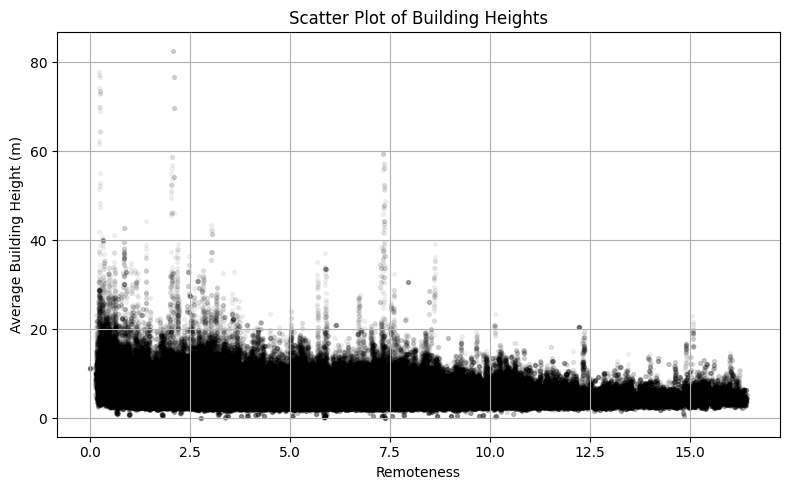

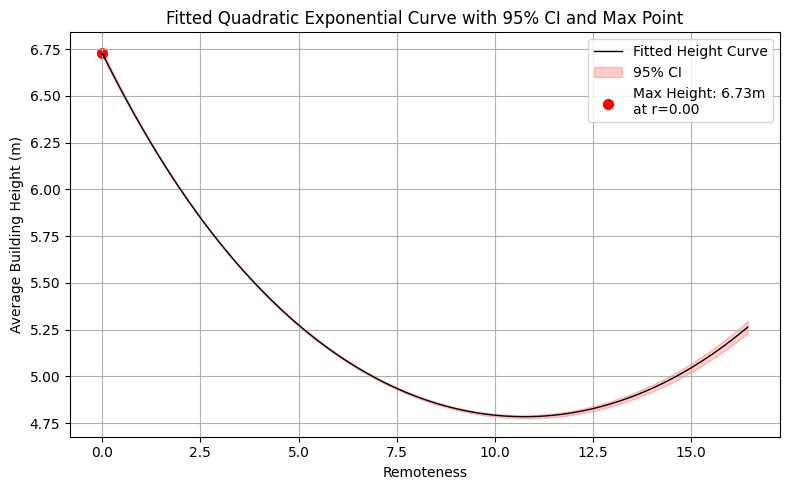

In [54]:
sample_and_fit_height_model(df_16, random_state=72)

Ê†∑Êú¨Èáè: 1323235
Fitted parameters:
  alpha = 17.9744 (95% CI: 17.8953, 18.0534)
  beta  = 0.1924 (95% CI: 0.1884, 0.1964)
  gamma = 0.0239 (95% CI: 0.0231, 0.0246)


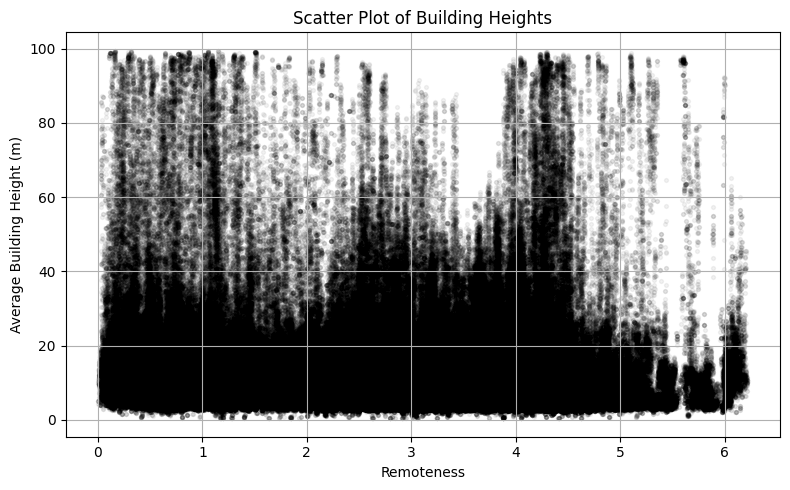

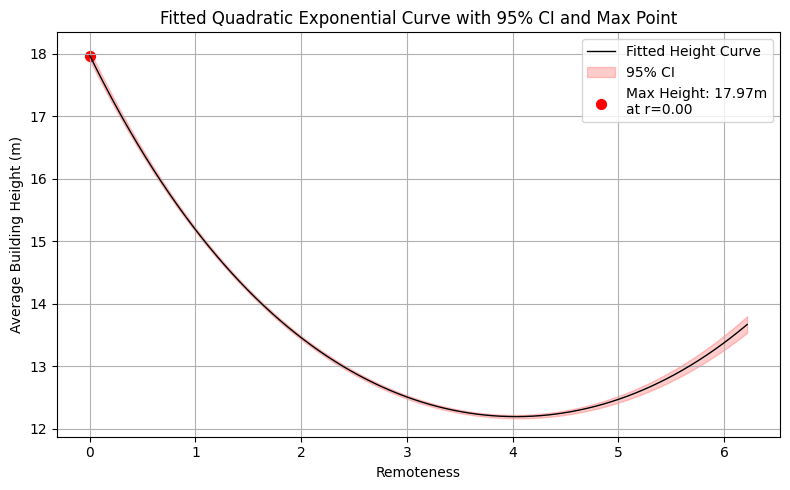

In [55]:
sample_and_fit_height_model(df_16_mumbai, random_state=72)

Ê†∑Êú¨Èáè: 8380218
Fitted parameters:
  alpha = 9.6875 (95% CI: 9.6683, 9.7067)
  beta  = 0.1837 (95% CI: 0.1821, 0.1853)
  gamma = 0.0134 (95% CI: 0.0131, 0.0137)


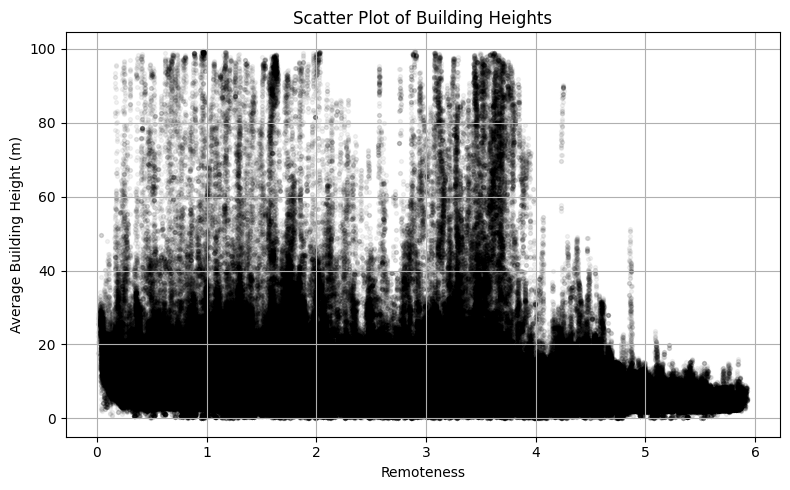

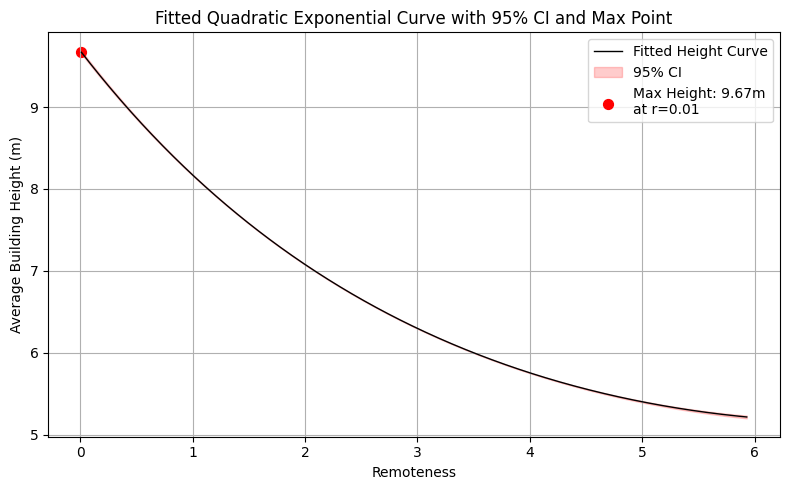

In [56]:
sample_and_fit_height_model(df_16_mexico,random_state=72)

## ÊâπÈáèÊãüÂêà

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# ÂÆö‰πâ‰∫åÊ¨°ÊåáÊï∞ÂáΩÊï∞
def height_model(remoteness, alpha, beta, gamma):
    return alpha * np.exp(-beta * remoteness + gamma * remoteness**2)

def fit_height_model_for_city(df):
    """ÂØπÂçï‰∏™ÂüéÂ∏ÇÁöÑÊï∞ÊçÆËøõË°åÊãüÂêà"""
    # Á≠õÈÄâÊúâÊïàÊï∞ÊçÆ
    df_nz = df[(df['avg_height'] > 0) & (df['building_count'] > 0)]
    
    if len(df_nz) < 10:  # Â¶ÇÊûúÊï∞ÊçÆÈáèÂ§™Â∞ëÔºåË∑≥Ëøá
        return None
    
    xdata = df_nz['remoteness'].values
    ydata = df_nz['avg_height'].values
    
    # ÂàùÂßãÂèÇÊï∞
    p0 = [10, 0.1, 0.01]
    
    try:
        params, covariance = curve_fit(
            height_model, xdata, ydata, p0=p0, maxfev=20000
        )
        alpha, beta, gamma = params
        
        # ËÆ°ÁÆóÁΩÆ‰ø°Âå∫Èó¥
        se = np.sqrt(np.diag(covariance))
        ci_lower = params - 1.96 * se
        ci_upper = params + 1.96 * se
        
        return {
            'alpha': alpha,
            'beta': beta,
            'gamma': gamma,
            'alpha_ci_lower': ci_lower[0],
            'alpha_ci_upper': ci_upper[0],
            'beta_ci_lower': ci_lower[1],
            'beta_ci_upper': ci_upper[1],
            'gamma_ci_lower': ci_lower[2],
            'gamma_ci_upper': ci_upper[2],
            'sample_size': len(df_nz)
        }
    except Exception as e:
        print(f"    ÊãüÂêàÂ§±Ë¥•: {str(e)}")
        return None

# ËØªÂèñÂüéÂ∏ÇÂàóË°®
cities = pd.read_csv("CitiesDB_new.csv")

# ÂáÜÂ§áÁªìÊûúÂàóË°®
results = []

# ÈÅçÂéÜÊØè‰∏™ÂüéÂ∏ÇÂíåÂπ¥‰ªΩ
years = [2016, 2023]

print("ÂºÄÂßãÊâπÈáèÊãüÂêàheightÊ®°Âûã...")
print(f"ÊÄªÂÖ±ÈúÄË¶ÅÂ§ÑÁêÜ: {len(cities)} ‰∏™ÂüéÂ∏Ç √ó {len(years)} Âπ¥ = {len(cities) * len(years)} ‰∏™Êï∞ÊçÆÈõÜ\n")

# ‰ΩøÁî®tqdmÂàõÂª∫ËøõÂ∫¶Êù°
for idx, row in tqdm(cities.iterrows(), total=len(cities), desc="Â§ÑÁêÜÂüéÂ∏Ç"):
    city_name = row['Name']
    
    for year in years:
        try:
            # ÊûÑÂª∫Êñá‰ª∂Ë∑ØÂæÑ
            file_path = f"aggregated_data/{city_name}_{year}_3x3_windows.csv"
            
            # ËØªÂèñÊï∞ÊçÆ
            df = pd.read_csv(file_path)
            
            # Ëé∑Âèñ‰∫∫Âè£Êï∞ÊçÆ
            pop_col = f'pop_{year}_UN'
            if pop_col not in cities.columns:
                print(f"  ‚ö†Ô∏è  {city_name} {year}: Áº∫Â∞ë‰∫∫Âè£Êï∞ÊçÆÂàó {pop_col}")
                continue
                
            pop = row[pop_col] * 1000
            
            # ËÆ°ÁÆóremoteness
            df['remoteness'] = (df['distance_to_center'] / np.sqrt(pop)) * 1000
            df['bd'] = 9
            
            # ËøõË°åÊãüÂêà
            fit_result = fit_height_model_for_city(df)
            
            if fit_result is not None:
                # Ê∑ªÂä†ÂüéÂ∏ÇÂíåÂπ¥‰ªΩ‰ø°ÊÅØ
                fit_result['city'] = city_name
                fit_result['year'] = year
                fit_result['population'] = pop
                results.append(fit_result)
                print(f"  ‚úì {city_name} {year} ÂÆåÊàê (Ê†∑Êú¨Èáè: {fit_result['sample_size']})")
            else:
                print(f"  ‚úó {city_name} {year} ÊãüÂêàÂ§±Ë¥•")
                
        except FileNotFoundError:
            print(f"  ‚ö†Ô∏è  {city_name} {year}: Êñá‰ª∂‰∏çÂ≠òÂú®")
        except Exception as e:
            print(f"  ‚úó {city_name} {year}: ÂèëÁîüÈîôËØØ - {str(e)}")

# ËΩ¨Êç¢‰∏∫DataFrameÂπ∂‰øùÂ≠ò
results_df = pd.DataFrame(results)

# ÈáçÊñ∞ÊéíÂàóÂàóÁöÑÈ°∫Â∫è
column_order = [
    'city', 'year', 'population', 'sample_size',
    'alpha', 'alpha_ci_lower', 'alpha_ci_upper',
    'beta', 'beta_ci_lower', 'beta_ci_upper',
    'gamma', 'gamma_ci_lower', 'gamma_ci_upper'
]
results_df = results_df[column_order]

# ‰øùÂ≠òÁªìÊûú
results_df.to_csv('height_fitting_results.csv', index=False)

print("\n" + "="*60)
print("ÊâπÈáèÊãüÂêàÂÆåÊàêÔºÅ")
print(f"ÊàêÂäüÊãüÂêà: {len(results_df)} ‰∏™Êï∞ÊçÆÈõÜ")
print(f"ÁªìÊûúÂ∑≤‰øùÂ≠òÂà∞: height_fitting_results.csv")
print("="*60)

# ÊòæÁ§∫ÂâçÂá†Ë°åÁªìÊûú
print("\nÁªìÊûúÈ¢ÑËßà:")
print(results_df.head(10))

ÂºÄÂßãÊâπÈáèÊãüÂêàheightÊ®°Âûã...
ÊÄªÂÖ±ÈúÄË¶ÅÂ§ÑÁêÜ: 104 ‰∏™ÂüéÂ∏Ç √ó 2 Âπ¥ = 208 ‰∏™Êï∞ÊçÆÈõÜ



Â§ÑÁêÜÂüéÂ∏Ç:   0%|                                         | 0/104 [00:00<?, ?it/s]

  ‚úì Antananarivo 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 1157558)


Â§ÑÁêÜÂüéÂ∏Ç:   1%|‚ñé                                | 1/104 [00:10<17:42, 10.32s/it]

  ‚úì Antananarivo 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 1388524)
  ‚úì Abidjan 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 2230953)


Â§ÑÁêÜÂüéÂ∏Ç:   2%|‚ñã                                | 2/104 [00:21<18:25, 10.84s/it]

  ‚úì Abidjan 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 2926070)
  ‚úì Yaounde 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 1688897)


Â§ÑÁêÜÂüéÂ∏Ç:   3%|‚ñâ                                | 3/104 [00:33<19:09, 11.38s/it]

  ‚úì Yaounde 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 2189998)
  ‚úì Lusaka 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 1996955)


Â§ÑÁêÜÂüéÂ∏Ç:   4%|‚ñà‚ñé                               | 4/104 [00:44<18:50, 11.31s/it]

  ‚úì Lusaka 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 2694822)
  ‚úì Hanoi 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 3962536)


Â§ÑÁêÜÂüéÂ∏Ç:   5%|‚ñà‚ñå                               | 5/104 [00:57<19:26, 11.78s/it]

  ‚úì Hanoi 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 4573868)
  ‚úì Monterrey 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 4152160)


Â§ÑÁêÜÂüéÂ∏Ç:   6%|‚ñà‚ñâ                               | 6/104 [01:10<20:09, 12.34s/it]

  ‚úì Monterrey 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 4520128)
  ‚úì Buenos Aires 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 6474926)


Â§ÑÁêÜÂüéÂ∏Ç:   7%|‚ñà‚ñà‚ñè                              | 7/104 [01:28<22:50, 14.13s/it]

  ‚úì Buenos Aires 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 6570975)
  ‚úì Medan 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 3562883)


Â§ÑÁêÜÂüéÂ∏Ç:   8%|‚ñà‚ñà‚ñå                              | 8/104 [01:41<22:03, 13.78s/it]

  ‚úì Medan 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 3951887)
  ‚úì Cairo 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 5003108)


Â§ÑÁêÜÂüéÂ∏Ç:   9%|‚ñà‚ñà‚ñä                              | 9/104 [01:55<22:01, 13.91s/it]

  ‚úì Cairo 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 5304380)
  ‚úì Lagos 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 4349435)


Â§ÑÁêÜÂüéÂ∏Ç:  10%|‚ñà‚ñà‚ñà                             | 10/104 [02:09<21:30, 13.73s/it]

  ‚úì Lagos 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 4860304)
  ‚úì Onitsha 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 2144884)


Â§ÑÁêÜÂüéÂ∏Ç:  11%|‚ñà‚ñà‚ñà‚ñç                            | 11/104 [02:21<20:32, 13.25s/it]

  ‚úì Onitsha 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 2647491)
  ‚úì Johannesburg 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 5896597)


Â§ÑÁêÜÂüéÂ∏Ç:  12%|‚ñà‚ñà‚ñà‚ñã                            | 12/104 [02:38<22:13, 14.49s/it]

  ‚úì Johannesburg 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 6205373)
  ‚úì Kinshasa 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 2776264)


Â§ÑÁêÜÂüéÂ∏Ç:  12%|‚ñà‚ñà‚ñà‚ñà                            | 13/104 [02:51<21:10, 13.96s/it]

  ‚úì Kinshasa 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 2732789)
  ‚úì Luanda 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 3113025)


Â§ÑÁêÜÂüéÂ∏Ç:  13%|‚ñà‚ñà‚ñà‚ñà‚ñé                           | 14/104 [03:04<20:25, 13.62s/it]

  ‚úì Luanda 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 2551240)
  ‚úì Alexandria 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 1561332)


Â§ÑÁêÜÂüéÂ∏Ç:  14%|‚ñà‚ñà‚ñà‚ñà‚ñå                           | 15/104 [03:15<19:09, 12.92s/it]

  ‚úì Alexandria 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 1630860)
  ‚úì Nairobi 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 2901339)


Â§ÑÁêÜÂüéÂ∏Ç:  15%|‚ñà‚ñà‚ñà‚ñà‚ñâ                           | 16/104 [03:28<18:52, 12.87s/it]

  ‚úì Nairobi 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 3418637)
  ‚úì Dar es Salaam 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 3100812)


Â§ÑÁêÜÂüéÂ∏Ç:  16%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                          | 17/104 [03:41<19:00, 13.11s/it]

  ‚úì Dar es Salaam 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 3862885)
  ‚úì Kisumu 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 871146)


Â§ÑÁêÜÂüéÂ∏Ç:  17%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                          | 18/104 [03:54<18:37, 13.00s/it]

  ‚úì Kisumu 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 1058283)
  ‚úì Accra 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 3746231)


Â§ÑÁêÜÂüéÂ∏Ç:  18%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                          | 19/104 [04:09<19:13, 13.57s/it]

  ‚úì Accra 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 4444852)
  ‚úì Kano 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 1958132)


Â§ÑÁêÜÂüéÂ∏Ç:  19%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                         | 20/104 [04:22<18:38, 13.31s/it]

  ‚úì Kano 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 2457795)
  ‚úì Algiers 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 2165318)


Â§ÑÁêÜÂüéÂ∏Ç:  20%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                         | 21/104 [04:34<18:02, 13.04s/it]

  ‚úì Algiers 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 2321501)
  ‚úì Kampala 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 3197576)


Â§ÑÁêÜÂüéÂ∏Ç:  21%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                         | 22/104 [04:48<18:08, 13.28s/it]

  ‚úì Kampala 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 4132295)
  ‚úì Addis Ababa 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 2482888)


Â§ÑÁêÜÂüéÂ∏Ç:  22%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                         | 23/104 [05:01<17:43, 13.13s/it]

  ‚úì Addis Ababa 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 3129105)
  ‚úì Cape Town 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 2476531)


Â§ÑÁêÜÂüéÂ∏Ç:  23%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                        | 24/104 [05:14<17:35, 13.20s/it]

  ‚úì Cape Town 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 2570849)
  ‚úì Ibadan 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 3316328)


Â§ÑÁêÜÂüéÂ∏Ç:  24%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                        | 25/104 [05:28<17:39, 13.41s/it]

  ‚úì Ibadan 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 4076395)
  ‚úì Dakar 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 1248723)


Â§ÑÁêÜÂüéÂ∏Ç:  25%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                        | 26/104 [05:40<16:41, 12.84s/it]

  ‚úì Dakar 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 1407234)
  ‚úì Kumasi 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 2687765)


Â§ÑÁêÜÂüéÂ∏Ç:  26%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                       | 27/104 [05:53<16:35, 12.93s/it]

  ‚úì Kumasi 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 3567064)
  ‚úì Maputo 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 1929678)


Â§ÑÁêÜÂüéÂ∏Ç:  27%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                       | 28/104 [06:06<16:23, 12.95s/it]

  ‚úì Maputo 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 2392774)
  ‚úì Ouagadougou 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 1467080)


Â§ÑÁêÜÂüéÂ∏Ç:  28%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                       | 29/104 [06:17<15:25, 12.34s/it]

  ‚úì Ouagadougou 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 2434164)
  ‚úì Harare 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 1958618)


Â§ÑÁêÜÂüéÂ∏Ç:  29%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                      | 30/104 [06:28<14:46, 11.98s/it]

  ‚úì Harare 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 2430801)
  ‚úì Kigali 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 1403581)


Â§ÑÁêÜÂüéÂ∏Ç:  30%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                      | 31/104 [06:39<14:09, 11.63s/it]

  ‚úì Kigali 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 1870201)
  ‚úì Conakry 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 975235)


Â§ÑÁêÜÂüéÂ∏Ç:  31%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                      | 32/104 [06:50<13:57, 11.63s/it]

  ‚úì Conakry 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 1060641)
  ‚úì Abuja 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 2146400)


Â§ÑÁêÜÂüéÂ∏Ç:  32%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                     | 33/104 [07:02<13:58, 11.82s/it]

  ‚úì Abuja 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 2696915)
  ‚úì Aba 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 1477412)


Â§ÑÁêÜÂüéÂ∏Ç:  33%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                     | 34/104 [07:15<13:55, 11.93s/it]

  ‚úì Aba 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 1541469)
  ‚úì Brazzaville 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 2657547)


Â§ÑÁêÜÂüéÂ∏Ç:  34%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                     | 35/104 [07:28<14:13, 12.37s/it]

  ‚úì Brazzaville 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 2581630)
  ‚úì Freetown 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 749099)


Â§ÑÁêÜÂüéÂ∏Ç:  35%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                     | 36/104 [07:39<13:34, 11.97s/it]

  ‚úì Freetown 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 931275)
  ‚úì Mombasa 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 909394)


Â§ÑÁêÜÂüéÂ∏Ç:  36%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                    | 37/104 [07:50<13:02, 11.68s/it]

  ‚úì Mombasa 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 1130580)
  ‚úì Monrovia 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 999136)


Â§ÑÁêÜÂüéÂ∏Ç:  37%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                    | 38/104 [08:02<12:50, 11.68s/it]

  ‚úì Monrovia 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 1367699)
  ‚úì Lilongwe 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 827813)


Â§ÑÁêÜÂüéÂ∏Ç:  38%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                    | 39/104 [08:16<13:21, 12.34s/it]

  ‚úì Lilongwe 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 1103814)
  ‚úì Niamey 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 743044)


Â§ÑÁêÜÂüéÂ∏Ç:  38%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                   | 40/104 [08:27<12:57, 12.14s/it]

  ‚úì Niamey 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 1084605)
  ‚úì Nouakchott 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 784547)


Â§ÑÁêÜÂüéÂ∏Ç:  39%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                   | 41/104 [08:39<12:42, 12.10s/it]

  ‚úì Nouakchott 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 1066520)
  ‚úì Bujumbura 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 754113)


Â§ÑÁêÜÂüéÂ∏Ç:  40%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                   | 42/104 [08:51<12:21, 11.95s/it]

  ‚úì Bujumbura 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 949154)
  ‚úì Oran 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 1001390)


Â§ÑÁêÜÂüéÂ∏Ç:  41%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                  | 43/104 [09:03<12:06, 11.91s/it]

  ‚úì Oran 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 1091722)
  ‚úì Bangui 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 484607)


Â§ÑÁêÜÂüéÂ∏Ç:  42%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                  | 44/104 [09:15<11:52, 11.88s/it]

  ‚úì Bangui 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 676214)
  ‚úì Libreville 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 944648)


Â§ÑÁêÜÂüéÂ∏Ç:  43%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                  | 45/104 [09:26<11:36, 11.81s/it]

  ‚úì Libreville 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 1133248)
  ‚úì Constantine 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 823098)


Â§ÑÁêÜÂüéÂ∏Ç:  44%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                 | 46/104 [09:38<11:26, 11.84s/it]

  ‚úì Constantine 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 918130)
  ‚úì Bobo-Dioulasso 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 522601)


Â§ÑÁêÜÂüéÂ∏Ç:  45%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                 | 47/104 [09:50<11:12, 11.80s/it]

  ‚úì Bobo-Dioulasso 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 783362)
  ‚úì Windhoek 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 517157)


Â§ÑÁêÜÂüéÂ∏Ç:  46%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                 | 48/104 [10:02<11:07, 11.93s/it]

  ‚úì Windhoek 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 582577)
  ‚úì Jakarta 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 7657964)


Â§ÑÁêÜÂüéÂ∏Ç:  47%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                 | 49/104 [10:18<12:06, 13.22s/it]

  ‚úì Jakarta 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 8055817)
  ‚úì Delhi 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 5749026)


Â§ÑÁêÜÂüéÂ∏Ç:  48%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                | 50/104 [10:32<12:06, 13.46s/it]

  ‚úì Delhi 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 6027087)
  ‚úì Mumbai 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 1323235)


Â§ÑÁêÜÂüéÂ∏Ç:  49%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                | 51/104 [10:44<11:21, 12.86s/it]

  ‚úì Mumbai 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 1260869)
  ‚úì Manila 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 5024162)


Â§ÑÁêÜÂüéÂ∏Ç:  50%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                | 52/104 [10:59<11:43, 13.53s/it]

  ‚úì Manila 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 5271012)
  ‚úì Dhaka 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 3006813)


Â§ÑÁêÜÂüéÂ∏Ç:  51%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé               | 53/104 [11:12<11:21, 13.36s/it]

  ‚úì Dhaka 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 3518443)
  ‚úì Kolkata 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 5244192)


Â§ÑÁêÜÂüéÂ∏Ç:  52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå               | 54/104 [11:27<11:31, 13.83s/it]

  ‚úì Kolkata 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 5358912)
  ‚úì Bangkok 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 8348732)


Â§ÑÁêÜÂüéÂ∏Ç:  53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ               | 55/104 [11:44<12:08, 14.87s/it]

  ‚úì Bangkok 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 9057031)
  ‚úì Karachi 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 3436368)


Â§ÑÁêÜÂüéÂ∏Ç:  54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè              | 56/104 [11:57<11:28, 14.35s/it]

  ‚úì Karachi 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 3630105)
  ‚úì Bangalore 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 4529948)


Â§ÑÁêÜÂüéÂ∏Ç:  55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå              | 57/104 [12:12<11:19, 14.46s/it]

  ‚úì Bangalore 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 5171746)
  ‚úì Ho Chi Minh City 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 5280143)


Â§ÑÁêÜÂüéÂ∏Ç:  56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä              | 58/104 [12:27<11:18, 14.75s/it]

  ‚úì Ho Chi Minh City 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 5995475)
  ‚úì Chennai 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 3446918)


Â§ÑÁêÜÂüéÂ∏Ç:  57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè             | 59/104 [12:40<10:42, 14.28s/it]

  ‚úì Chennai 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 3684603)
  ‚úì Hyderabad 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 4357118)


Â§ÑÁêÜÂüéÂ∏Ç:  58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç             | 60/104 [12:55<10:29, 14.30s/it]

  ‚úì Hyderabad 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 5097792)
  ‚úì Kuala Lumpur 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 4348867)


Â§ÑÁêÜÂüéÂ∏Ç:  59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä             | 61/104 [13:10<10:26, 14.56s/it]

  ‚úì Kuala Lumpur 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 4638961)
  ‚úì Bandung 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 4161878)


Â§ÑÁêÜÂüéÂ∏Ç:  60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà             | 62/104 [13:25<10:16, 14.68s/it]

  ‚úì Bandung 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 4512840)
  ‚úì Pune 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 2653218)


Â§ÑÁêÜÂüéÂ∏Ç:  61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç            | 63/104 [13:38<09:45, 14.28s/it]

  ‚úì Pune 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 3130447)
  ‚úì Ahmedabad 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 2684685)


Â§ÑÁêÜÂüéÂ∏Ç:  62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã            | 64/104 [13:51<09:10, 13.76s/it]

  ‚úì Ahmedabad 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 3065199)
  ‚úì Surat 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 1760361)


Â§ÑÁêÜÂüéÂ∏Ç:  62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà            | 65/104 [14:03<08:38, 13.30s/it]

  ‚úì Surat 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 2018816)
  ‚úì Surabaya 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 3687096)


Â§ÑÁêÜÂüéÂ∏Ç:  63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé           | 66/104 [14:17<08:37, 13.61s/it]

  ‚úì Surabaya 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 4024617)
  ‚úì Jaipur 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 2743127)


Â§ÑÁêÜÂüéÂ∏Ç:  64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå           | 67/104 [14:30<08:16, 13.43s/it]

  ‚úì Jaipur 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 3270490)
  ‚úì Phnom Penh 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 1934730)


Â§ÑÁêÜÂüéÂ∏Ç:  65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ           | 68/104 [14:44<08:00, 13.35s/it]

  ‚úì Phnom Penh 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 2817230)
  ‚úì Denpasar 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 2722055)


Â§ÑÁêÜÂüéÂ∏Ç:  66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè          | 69/104 [14:58<08:01, 13.75s/it]

  ‚úì Denpasar 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 3046745)
  ‚úì Davao 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 1005712)


Â§ÑÁêÜÂüéÂ∏Ç:  67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå          | 70/104 [15:10<07:29, 13.22s/it]

  ‚úì Davao 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 1304968)
  ‚úì Semarang 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 2503763)


Â§ÑÁêÜÂüéÂ∏Ç:  68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä          | 71/104 [15:24<07:22, 13.42s/it]

  ‚úì Semarang 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 2801679)
  ‚úì Palembang 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 1670961)


Â§ÑÁêÜÂüéÂ∏Ç:  69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè         | 72/104 [15:37<07:03, 13.23s/it]

  ‚úì Palembang 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 1941851)
  ‚úì Makassar 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 1591431)


Â§ÑÁêÜÂüéÂ∏Ç:  70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç         | 73/104 [15:49<06:43, 13.02s/it]

  ‚úì Makassar 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 1857910)
  ‚úì Batam 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 1192020)


Â§ÑÁêÜÂüéÂ∏Ç:  71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä         | 74/104 [16:02<06:23, 12.78s/it]

  ‚úì Batam 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 1341989)
  ‚úì Bandar Lampung 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 1636852)


Â§ÑÁêÜÂüéÂ∏Ç:  72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà         | 75/104 [16:14<06:10, 12.77s/it]

  ‚úì Bandar Lampung 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 1919586)
  ‚úì Kathmandu 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 1731642)


Â§ÑÁêÜÂüéÂ∏Ç:  73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç        | 76/104 [16:27<05:54, 12.65s/it]

  ‚úì Kathmandu 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 2275523)
  ‚úì Sao Paulo 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 8884227)


Â§ÑÁêÜÂüéÂ∏Ç:  74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã        | 77/104 [16:46<06:35, 14.65s/it]

  ‚úì Sao Paulo 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 9067164)
  ‚úì Mexico City 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 8380218)


Â§ÑÁêÜÂüéÂ∏Ç:  75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà        | 78/104 [17:04<06:47, 15.68s/it]

  ‚úì Mexico City 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 8597739)
  ‚úì Rio de Janeiro 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 3537181)


Â§ÑÁêÜÂüéÂ∏Ç:  76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé       | 79/104 [17:19<06:24, 15.39s/it]

  ‚úì Rio de Janeiro 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 3604537)
  ‚úì Lima 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 4059883)


Â§ÑÁêÜÂüéÂ∏Ç:  77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå       | 80/104 [17:33<05:58, 14.93s/it]

  ‚úì Lima 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 3756851)
  ‚úì Bogota 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 2944665)


Â§ÑÁêÜÂüéÂ∏Ç:  78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ       | 81/104 [17:46<05:29, 14.31s/it]

  ‚úì Bogota 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 3087787)
  ‚úì Guadalajara 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 4245167)


Â§ÑÁêÜÂüéÂ∏Ç:  79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè      | 82/104 [18:00<05:17, 14.41s/it]

  ‚úì Guadalajara 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 4558785)
  ‚úì Belo Horizonte 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 3995847)


Â§ÑÁêÜÂüéÂ∏Ç:  80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå      | 83/104 [18:15<05:07, 14.63s/it]

  ‚úì Belo Horizonte 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 4231898)
  ‚úì Brasilia 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 1913906)


Â§ÑÁêÜÂüéÂ∏Ç:  81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä      | 84/104 [18:29<04:45, 14.30s/it]

  ‚úì Brasilia 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 2130060)
  ‚úì Guatemala City 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 2540295)


Â§ÑÁêÜÂüéÂ∏Ç:  82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè     | 85/104 [18:42<04:26, 14.04s/it]

  ‚úì Guatemala City 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 2866387)
  ‚úì Salvador 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 1552945)


Â§ÑÁêÜÂüéÂ∏Ç:  83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç     | 86/104 [18:54<04:01, 13.42s/it]

  ‚úì Salvador 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 1655546)
  ‚úì La Paz 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 1625706)


Â§ÑÁêÜÂüéÂ∏Ç:  84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä     | 87/104 [19:07<03:42, 13.07s/it]

  ‚úì La Paz 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 1965985)
  ‚úì Guayaquil 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 1788128)


Â§ÑÁêÜÂüéÂ∏Ç:  85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà     | 88/104 [19:19<03:24, 12.78s/it]

  ‚úì Guayaquil 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 2011303)
  ‚úì Santo Domingo 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 2037540)


Â§ÑÁêÜÂüéÂ∏Ç:  86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç    | 89/104 [19:32<03:12, 12.81s/it]

  ‚úì Santo Domingo 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 2311861)
  ‚úì Medellin 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 1890194)


Â§ÑÁêÜÂüéÂ∏Ç:  87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã    | 90/104 [19:45<03:00, 12.89s/it]

  ‚úì Medellin 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 2088081)
  ‚úì Cali 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 1344659)


Â§ÑÁêÜÂüéÂ∏Ç:  88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà    | 91/104 [19:57<02:46, 12.80s/it]

  ‚úì Cali 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 1514631)
  ‚úì Quito 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 2422568)


Â§ÑÁêÜÂüéÂ∏Ç:  88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 92/104 [20:12<02:38, 13.23s/it]

  ‚úì Quito 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 2690586)
  ‚úì Tegucigalpa 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 919946)


Â§ÑÁêÜÂüéÂ∏Ç:  89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 93/104 [20:24<02:23, 13.00s/it]

  ‚úì Tegucigalpa 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 1096652)
  ‚úì Leon 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 1724944)


Â§ÑÁêÜÂüéÂ∏Ç:  90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 94/104 [20:37<02:09, 12.95s/it]

  ‚úì Leon 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 1976297)
  ‚úì Puebla 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 2867702)


Â§ÑÁêÜÂüéÂ∏Ç:  91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè  | 95/104 [20:51<01:59, 13.32s/it]

  ‚úì Puebla 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 3145680)
  ‚úì San Jose 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 2786067)


Â§ÑÁêÜÂüéÂ∏Ç:  92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 96/104 [21:05<01:47, 13.47s/it]

  ‚úì San Jose 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 3046057)
  ‚úì Managua 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 1260329)


Â§ÑÁêÜÂüéÂ∏Ç:  93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä  | 97/104 [21:17<01:32, 13.18s/it]

  ‚úì Managua 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 1375286)
  ‚úì Port-au-Prince 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 1479292)


Â§ÑÁêÜÂüéÂ∏Ç:  94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè | 98/104 [21:30<01:18, 13.05s/it]

  ‚úì Port-au-Prince 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 1718792)
  ‚úì Merida 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 1852617)


Â§ÑÁêÜÂüéÂ∏Ç:  95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç | 99/104 [21:44<01:07, 13.41s/it]

  ‚úì Merida 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 2114587)
  ‚úì Cancun 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 719118)


Â§ÑÁêÜÂüéÂ∏Ç:  96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä | 100/104 [21:56<00:51, 12.99s/it]

  ‚úì Cancun 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 851303)
  ‚úì Queretaro 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 1735467)


Â§ÑÁêÜÂüéÂ∏Ç:  97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà | 101/104 [22:09<00:38, 12.97s/it]

  ‚úì Queretaro 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 2119481)
  ‚úì Acapulco 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 774843)


Â§ÑÁêÜÂüéÂ∏Ç:  98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç| 102/104 [22:21<00:25, 12.73s/it]

  ‚úì Acapulco 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 830556)
  ‚úì San Salvador 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 1692485)


Â§ÑÁêÜÂüéÂ∏Ç:  99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 103/104 [22:35<00:12, 12.85s/it]

  ‚úì San Salvador 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 1906563)
  ‚úì Asuncion 2016 ÂÆåÊàê (Ê†∑Êú¨Èáè: 2579468)


Â§ÑÁêÜÂüéÂ∏Ç: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 104/104 [22:48<00:00, 13.16s/it]

  ‚úì Asuncion 2023 ÂÆåÊàê (Ê†∑Êú¨Èáè: 2958174)

ÊâπÈáèÊãüÂêàÂÆåÊàêÔºÅ
ÊàêÂäüÊãüÂêà: 208 ‰∏™Êï∞ÊçÆÈõÜ
ÁªìÊûúÂ∑≤‰øùÂ≠òÂà∞: height_fitting_results.csv

ÁªìÊûúÈ¢ÑËßà:
           city  year  population  sample_size      alpha  alpha_ci_lower  \
0  Antananarivo  2016   2757316.0      1157558   6.729840        6.716246   
1  Antananarivo  2023   3872264.0      1388524   7.150413        7.135700   
2       Abidjan  2016   4658790.0      2230953   6.373408        6.356882   
3       Abidjan  2023   5686350.0      2926070   6.681455        6.665887   
4       Yaounde  2016   3272870.0      1688897   6.253017        6.243561   
5       Yaounde  2023   4509287.0      2189998   6.149781        6.140468   
6        Lusaka  2016   2294091.0      1996955   5.300918        5.289125   
7        Lusaka  2023   3181250.0      2694822   5.624860        5.613207   
8         Hanoi  2016   3854847.0      3962536  15.949064       15.908620   
9         Hanoi  2023   5253385.0      4573868  16.986804       16

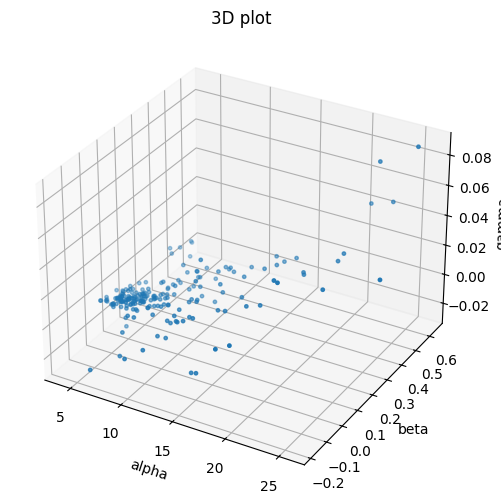

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

# ÂÅáËÆæÊï∞ÊçÆÂ¶Ç‰∏ã
# ÂüéÂ∏Ç,ÂèÇÊï∞A,ÂèÇÊï∞B,ÂèÇÊï∞C
df = pd.read_csv("height_fitting_results.csv")

# ÂàõÂª∫3DÂùêÊ†áËΩ¥
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')

# ÁªòÂà∂Êï£ÁÇπ
sc = ax.scatter(
    df["alpha"], 
    df["beta"], 
    df["gamma"],
    s=6
)

# Ê∑ªÂä†ÂùêÊ†áËΩ¥Ê†áÁ≠æ
ax.set_xlabel("alpha")
ax.set_ylabel("beta")
ax.set_zlabel("gamma")
ax.set_title("3D plot")

# ÂèØÈÄâÔºöÊ∑ªÂä†È¢úËâ≤Êù°
#plt.colorbar(sc, ax=ax, label="ÂèÇÊï∞A ÂÄº")

plt.show()